# Metric-based Quantum Architecture Search

## Required imports

In [710]:
import numpy as np
import scipy

import time
import os

from itertools import combinations, product
from functools import reduce
import copy

import pennylane as qml
from pennylane.templates.layers import RandomLayers
# from pennylane import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from scipy.stats import spearmanr

# import gym

In [2]:
!pip install --upgrade pennylane
# !pip install gym

  Using cached PennyLane-0.23.1-py3-none-any.whl (914 kB)
     |████████████████████████████████| 1.6 MB 23.9 MB/s            
  Using cached autograd-1.4-py3-none-any.whl (48 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
     |████████████████████████████████| 2.0 MB 61.9 MB/s            
  Using cached autoray-0.3.1-py3-none-any.whl (36 kB)
     |████████████████████████████████| 8.7 MB 6.7 MB/s            
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached semantic_version-2.6.0-py3-none-any.whl (14 kB)
  Using cached ninja-1.10.2.3-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (108 kB)
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


## Import and test python files

In [713]:
from create_gate_circ import generate_random_gate_circ, generate_true_random_gate_circ, create_gate_circ, create_batched_gate_circ

In [714]:
num_qubits = 2
num_embeds = 4
num_params = 4

ent_prob = np.random.sample()
cxz = np.random.sample()
pauli = 0

circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0], 'exp', 'adjoint') 

In [716]:
circ([0, 0, 1, 1], [1, 2, 3, 1])

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.06037322])>

## Circuit layers

In [4]:
def rot_layer(_, params):
    for i in range(len(params) // 3):
        qml.Rot(params[3 * i], params[3 * i + 1], params[3 * i + 2], wires=i)


def ry_layer(_, params):
    for i in range(len(params)):
        qml.RY(params[i], wires=i)
    

def rx_layer(_, params):
    for i in range(len(params)):
        qml.RX(params[i], wires=i)
        

def rz_layer(_, params):
    for i in range(len(params)):
        qml.RZ(params[i], wires=i)
        

def cr_layer(gate, cr_map, num_qubits, params):
    gate = {'crz': qml.CRZ, 'cry': qml.CRY, 'crx': qml.CRX}[gate]

    if cr_map == 'linear':
        for i, theta in enumerate(params):
            gate(theta, wires=[i % num_qubits, (i + 1) % num_qubits])
    elif cr_map == 'full':
        for i in range(num_qubits - 1):
            offset = sum(range(num_qubits - i, num_qubits))
            for j in range(num_qubits - i - 1):
                gate(params[offset + j], wires=[i, i + j + 1])


def hadamard_layer(num_qubits, _):
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
        

def c_layer(gate, c_map, num_qubits, _):
    gate = {'cz': qml.CZ, 'cy': qml.CY, 'cx': qml.CNOT}[gate]
    
    if c_map == 'full':
        for i in range(num_qubits - 1):
            for j in range(num_qubits - i - 1):
                gate(wires=[i, i + j + 1])        
        
    if c_map == 'linear':
        for i in range(num_qubits - 1):
            gate(wires=[i, i + 1])
                
    if c_map == 'linear_adj':
        for i in range(num_qubits - 2, -1, -1):
            gate(wires=[i, i + 1])            
                
    if c_map == 'linear_rev':
        for i in range(num_qubits - 1):
            gate(wires=[num_qubits - i - 1, num_qubits - i - 2]) 
                
    if c_map == 'linear_rev_adj':
        for i in range(num_qubits - 1):
            gate(wires=[i + 1, i])

    if c_map == 'circular':
        for i in range(num_qubits):
            gate(wires=[i, (i + 1) % num_qubits])
            
    if c_map == 'circular_adj':
        for i in range(num_qubits - 1, -1 , -1):
            gate(wires=[i, (i + 1) % num_qubits])

## Construct circuit

In [5]:
def torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, 
                        measured_qubits, ret_type='exp'):
    @qml.qnode(dev, interface='tf')
    def torch_qnn(inputs, weights): 
        for i, layer in enumerate(layers):
            if weights_bounds[i] == weights_bounds[i + 1]:
                data_in = inputs[inputs_bounds[i]: inputs_bounds[i + 1]]
            else:
                data_in = weights[weights_bounds[i]: weights_bounds[i + 1]]   

            layer(*layer_extra_params[i], data_in)     
        
        if ret_type == 'exp':
            return [qml.expval(qml.PauliZ(wires=i)) for i in measured_qubits]
        elif ret_type == 'state':
            return qml.state()
        else:
            return qml.probs(range(num_qubits))
    
    return torch_qnn


def get_inner_prod_circ(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits):    
    new_layers = layers + layers[::-1]
    new_layer_extra_params = copy.deepcopy(layer_extra_params) + copy.deepcopy(layer_extra_params)[::-1]
    new_weights_bounds = weights_bounds.copy()
    new_inputs_bounds = inputs_bounds.copy()
    
    for i in range(1, len(weights_bounds)):
        new_weights_bounds.append(new_weights_bounds[-1] + weights_bounds[-i] - weights_bounds[-(i + 1)])
        new_inputs_bounds.append(new_inputs_bounds[-1] + inputs_bounds[-i] - inputs_bounds[-(i + 1)])
        
    for i in range(len(layers), 2 * len(layers)):
        if new_layers[i] == c_layer:
            new_layer_extra_params[i][1] += '_adj'

    inner_prod_circ = torch_qnn_generator(dev, num_qubits, new_layers, 
                                       new_layer_extra_params, new_weights_bounds, new_inputs_bounds, measured_qubits, 'prob')
    
    def get_adj_params(params):
        adj_params = -1 * params.numpy()

        for i in range(len(layers)):
            if layers[i] in [rx_layer, rz_layer, ry_layer]:
                temp = np.copy(adj_params[weights_bounds[i]:weights_bounds[i + 1]])[::-1]

                for j in range(weights_bounds[i], weights_bounds[i + 1]):
                    adj_params[j] = temp[j - weights_bounds[i]]
        return tf.constant(adj_params[::-1], dtype=tf.float64)
    
    return inner_prod_circ, get_adj_params


def generate_random_circ(dev, num_embeds, num_var_layers, ratio_cx, data_dim, num_qubits, seeds):
    rots = [qml.RY, qml.RX]

    var_layer_dist = [0]
    weights_shape = (num_var_layers, num_qubits)
    avg_layers_btw_encodings = num_var_layers / (num_embeds + 1)
    
    for i in range(num_embeds):
        upper_lim = 1 + num_var_layers - (num_embeds - i) - sum(var_layer_dist)
        probs = []
        
        for i in range(1, upper_lim):
            probs.append(1 / np.sqrt(np.abs(i - avg_layers_btw_encodings) + 1))
            
        probs = np.array(probs) / np.sum(probs)
        
        var_layer_dist.append(np.random.choice(range(1, upper_lim), p=probs))
        
    var_layer_dist.append(num_var_layers - sum(var_layer_dist))
    
    @qml.qnode(dev, interface='tf')
    def circ(data, weights):
        for i in range(num_embeds):  
            data = np.copy(data).reshape(num_embeds, data_dim)
            weights_beg = var_layer_dist[i]
            weights_end = var_layer_dist[i + 1]
            
            RandomLayers(weights=weights[weights_beg:weights_end], imprimitive=qml.CNOT, rotations=rots, 
                         wires=range(num_qubits), seed=seeds[i], ratio_imprim=ratio_cx)
            
            RandomLayers(weights=data[i:i + 1], imprimitive=qml.CNOT, rotations=rots, wires=range(num_qubits), 
                         seed=seeds[-1], ratio_imprim=0)
            
        RandomLayers(weights=weights[weights_end:], imprimitive=qml.CNOT, rotations=rots, wires=range(num_qubits), 
                     seed=seeds[-2], ratio_imprim=ratio_cx)    
        
        return qml.expval(qml.PauliZ(0))    
    
    return circ, var_layer_dist, weights_shape


def generate_random_layer_circ(dev, num_qubits, num_embeds, num_vars):
    nc = np.random.choice
    
    def get_num_params(layer_props):
        params_mapping = {
            'linear': num_qubits - 1,
            'linear_rev': num_qubits - 1,
            'circular': num_qubits
        }
        
        if layer_props[0] in [rx_layer, rz_layer, ry_layer]:
            return num_qubits
        else:
            return params_mapping[layer_props[1][1]]

    embed_choices = ['ry', 'rx', 'rz']
    var_choices = ['ry', 'rx', 'rz', 'cr']
    cr_choices = ['crz', 'cry', 'crx']
    c_choices = ['cz', 'cx']
    ent_choices = ['linear', 'linear_rev', 'circular']
    
    layer_mapping = {
        'ry': ry_layer,
        'rx': rx_layer,
        'rz': rz_layer,
        'cr': cr_layer,
        'c': c_layer
    }
    
    var_layer_dist = []
    avg_layers_btw_encodings = num_vars / (num_embeds + 1)
    
    for i in range(num_embeds):
        upper_lim = 1 + num_vars - (num_embeds - i) - sum(var_layer_dist)
        probs = []
        
        for j in range(1, upper_lim):
            probs.append(1 / np.sqrt(np.abs(j - avg_layers_btw_encodings) + 1e-1))
            
        probs = np.array(probs) / np.sum(probs)
        
        var_layer_dist.append(np.random.choice(range(1, upper_lim), p=probs))
        
    var_layer_dist.append(num_vars - sum(var_layer_dist))   

    var_layers = []
    
    for i in var_layer_dist:
        var_layers.append(np.random.choice(var_choices, i))
        
    embed_layers = np.random.choice(embed_choices, num_embeds)
    
    layers = []
    layer_extra_params = []
    weights_bounds = [0]
    inputs_bounds = [0]
    
    for i in range(len(var_layers)):
        for j in range(len(var_layers[i])):
            var_layer_name = layer_mapping[var_layers[i][j]]
            ent_layer_props = [c_layer, [nc(c_choices), nc(ent_choices), num_qubits]]
            
            layers.append(var_layer_name)
            
            if var_layers[i][j] == 'cr':
                layer_params = [nc(cr_choices), nc(ent_choices), num_qubits]
            else:
                layer_params = [None]
        
            layer_extra_params.append(layer_params)
            weights_bounds.append(weights_bounds[-1] + get_num_params([var_layer_name, layer_params]))
            inputs_bounds.append(inputs_bounds[-1])
            
            layers.append(ent_layer_props[0])
            layer_extra_params.append(ent_layer_props[1])  
            weights_bounds.append(weights_bounds[-1])
            inputs_bounds.append(inputs_bounds[-1])
            
        if not i == len(var_layers) - 1:
            enc_layer_name = layer_mapping[embed_layers[i]]   
            ent_layer_props = [c_layer, [nc(c_choices), nc(ent_choices), num_qubits]]
            
            layers.append(enc_layer_name)
            
            if embed_layers[i] == 'cr':
                layer_params = [nc(cr_choices), nc(ent_choices), num_qubits]
            else:
                layer_params = [None]            

            layer_extra_params.append(layer_params)
            inputs_bounds.append(inputs_bounds[-1] + get_num_params([enc_layer_name, layer_params]))
            weights_bounds.append(weights_bounds[-1])
            
            layers.append(ent_layer_props[0])
            layer_extra_params.append(ent_layer_props[1])  
            weights_bounds.append(weights_bounds[-1])
            inputs_bounds.append(inputs_bounds[-1])
            
    return layers, layer_extra_params, weights_bounds, inputs_bounds


def get_rand_circ_params(dir_path):
    mapping = {
        ry_layer: 'ry',
        rx_layer: 'rx',
        rz_layer: 'rz',
        c_layer: 'c',
        cr_layer: 'cr'
    }

    inv_mapping = {mapping[k]: k for k in mapping.keys()}
    num_qubits = 0

    vals = np.genfromtxt(dir_path + '/layers.txt', dtype='str')
    layers = [inv_mapping[l] for l in vals]
    
    layer_params = open(dir_path + '/layer_extra_params.txt', 'r')
    layer_extra_params = []
    
    layer_extra_params = [j[1:-1].split(',') for j in layer_params.read().split('\n')[:-1]]
    for l in layer_extra_params:
        if len(l) == 1:
            if l[0] == 'None':
                l[0] = None
        elif len(l) == 3:
            l[0] = l[0][1:-1]
            l[1] = l[1][2:-1]
            l[2] = int(l[2])
            num_qubits = l[2]
            
    weights_bounds = list(np.genfromtxt(dir_path + '/weights_bounds.txt').astype('int'))
    inputs_bounds = list(np.genfromtxt(dir_path + '/inputs_bounds.txt').astype('int'))
    
    return layers, layer_extra_params, weights_bounds, inputs_bounds, num_qubits

In [ ]:
def generate_random_gate_circ(num_qubits, num_embed_gates, num_var_params=None, ent_prob=0.5, 
                              cxz_prob=0.2, pauli_prob=0.1, consecutive_embeds=True):   
    circ_gates = ['cx']
    inputs_bounds = [0]
    weights_bounds = [0]
    gate_params = []

    qubit_choices = [0, 1]
    gate_choices = [['ry', 'rz', 'rx'], ['cx', 'cz', 'crz', 'crx', 'cry', 'xx', 'yy', 'zz']]
    probs = [1 - ent_prob, ent_prob]
    c_probs = [cxz_prob / (2 * ent_prob) for i in range(2)] + [(1 - ((cxz_prob + pauli_prob) / ent_prob)) / 3 for i in range(3)]
    c_probs += [pauli_prob / (3 * ent_prob) for i in range(3)]

    r_probs = [1 / 3 for i in range(3)]
    gate_probs = [r_probs, c_probs]
    gate_qubits = 1
    
    max_params = num_embed_gates + num_var_params
    
    if consecutive_embeds:
        embed_positions = np.sort(np.random.choice(max_params, num_embed_gates, False))
    else:
        consecutive = True
        
        while consecutive:
            embed_positions = np.sort(np.random.choice(max_params, num_embed_gates, False))
            diffs = [embed_positions[i + 1] - embed_positions[i] for i in range(len(embed_positions) - 1)]
            consecutive = True if 1 in diffs else False

            if num_embed_gates > num_var_params:
                consecutive = False
        
    while weights_bounds[-1] + inputs_bounds[-1] < max_params:
        flag = False
            
        while not flag:
            gate_qubits = np.random.choice(qubit_choices, p=probs)
            curr_gate = np.random.choice(gate_choices[gate_qubits], p=gate_probs[gate_qubits])

            if curr_gate == circ_gates[-1]:
                pass
            else:
                if curr_gate in ['cx', 'cz']:
                    if len(circ_gates) in embed_positions or circ_gates[-1] in ['cx', 'cz']:
                        pass
                    else:
                        flag = True
                        inputs_bounds.append(inputs_bounds[-1])
                        weights_bounds.append(weights_bounds[-1])
                else:
                    flag = True

                    if weights_bounds[-1] + inputs_bounds[-1] in embed_positions:
                        inputs_bounds.append(inputs_bounds[-1] + 1)
                        weights_bounds.append(weights_bounds[-1])
                    else:
                        inputs_bounds.append(inputs_bounds[-1])
                        weights_bounds.append(weights_bounds[-1] + 1)                        

        comp_index = 0
            
        for i in range(len(gate_params)):
            if len(gate_params[-(i + 1)]) == gate_qubits + 1:
                comp_index = -(i + 1)
                break
                    
        new_params = np.random.choice(num_qubits, gate_qubits + 1, False) 
            
        if comp_index != 0:
            while (np.all(new_params == gate_params[comp_index]) or np.all(new_params[::1] == gate_params[comp_index])):
                new_params = np.random.choice(num_qubits, gate_qubits + 1, False)
        
        curr_comp_index = 0
        
        for i in range(len(gate_params) - 1):
            if len(gate_params[-(i + 1)] == len(new_params)):
                if np.all(gate_params[-(i + 1)] == new_params) or np.all(gate_params[-(i + 1)] == new_params[::-1]):
                    curr_comp_index = -(i + 1)
                    break
        
        new_gate = curr_gate
        
        if curr_comp_index != 0:
            if inputs_bounds[-1] > inputs_bounds[-2] or weights_bounds[-1] > weights_bounds[-2]:
                new_gate = np.random.choice(gate_choices[gate_qubits], p=gate_probs[gate_qubits])

                while new_gate in ['cx', 'cz', circ_gates[curr_comp_index]]:
                    new_gate = np.random.choice(gate_choices[gate_qubits], p=gate_probs[gate_qubits])
            else:
                if circ_gates[curr_comp_index] == 'cx':
                    new_gate = 'cz'
                else:
                    new_gate = 'cx'
            
        gate_params.append(new_params)
        circ_gates.append(new_gate)

    return circ_gates[1:], gate_params, inputs_bounds, weights_bounds


def generate_true_random_gate_circ(num_qubits, num_embed_gates, num_var_params=None, ent_prob=0.5, 
                              cxz_prob=0.2, pauli_prob=0.1):
    circ_gates = []
    inputs_bounds = [0]
    weights_bounds = [0]
    gate_params = []

    qubit_choices = [0, 1]
    gate_choices = [['ry', 'rz', 'rx'], ['cx', 'cz', 'crz', 'crx', 'cry', 'xx', 'yy', 'zz']]
    probs = [1 - ent_prob, ent_prob]
    c_probs = [cxz_prob / (2 * ent_prob) for i in range(2)] + [(1 - ((cxz_prob + pauli_prob) / ent_prob)) / 3 for i in range(3)]
    c_probs += [pauli_prob / (3 * ent_prob) for i in range(3)]

    r_probs = [1 / 3 for i in range(3)]
    gate_probs = [r_probs, c_probs]    
    max_params = num_embed_gates + num_var_params
    param_indices = []
    
    circ_params = 0
    curr_index = 0
    
    while circ_params < max_params:
        gate_qubits = np.random.choice(qubit_choices, p=probs)
        circ_gates.append(np.random.choice(gate_choices[gate_qubits], p=gate_probs[gate_qubits]))
        gate_params.append(np.random.choice(num_qubits, gate_qubits + 1, False))
        
        if circ_gates[-1] not in ['cx', 'cz']:
            circ_params += 1
            param_indices.append(curr_index)
            
        curr_index += 1
    
    embeds_indices = np.random.choice(param_indices, num_embed_gates, False)
    
    for i in range(len(circ_gates)):
        if circ_gates[i] in ['cx', 'cz']:
            inputs_bounds.append(inputs_bounds[-1])
            weights_bounds.append(weights_bounds[-1])
        else:
            if i in embeds_indices:
                inputs_bounds.append(inputs_bounds[-1] + 1)
                weights_bounds.append(weights_bounds[-1])
            else:
                inputs_bounds.append(inputs_bounds[-1])
                weights_bounds.append(weights_bounds[-1] + 1)
                
    return circ_gates, gate_params, inputs_bounds, weights_bounds


def create_gate_circ(dev, gates, gate_params, inputs_bounds, weights_bounds, measured_qubits, ret_type='exp', diff_method='best'):
    mapping = {
        'ry': qml.RY,
        'rx': qml.RX,
        'rz': qml.RZ,
        'cx': qml.CNOT,
        'cz': qml.CZ,
        'cry': qml.CRY,
        'crz': qml.CRZ,
        'crx': qml.CRX,
        'yy': qml.IsingYY,
        'zz': qml.IsingZZ,
        'xx': qml.IsingXX,
        'rot': qml.Rot,
        'meas': qml.measure,
        'h': qml.Hadamard,
        's': qml.S,
        'x': qml.PauliX,
        'y': qml.PauliY,
        'z': qml.PauliZ,
        'iqp': qml.IQPEmbedding
    }   

    @qml.qnode(dev, interface='tf', diff_method=diff_method)
    def torch_qnn(inputs, weights): 
        for i, gate in enumerate(gates):
            if weights_bounds[i] == weights_bounds[i + 1]:
                data_in = inputs[inputs_bounds[i]: inputs_bounds[i + 1]]
            else:
                data_in = weights[weights_bounds[i]: weights_bounds[i + 1]]   

            mapping[gate](*data_in, wires=gate_params[i])     
        
        if ret_type == 'exp':
            return [qml.expval(qml.PauliZ(wires=i)) for i in measured_qubits]
        elif ret_type == 'state':
            return qml.state()
        elif ret_type == 'sample':
            return qml.sample(wires=measured_qubits)
        elif ret_type == 'matrix':
            return qml.density_matrix(wires=measured_qubits)
        else:
            return qml.probs(dev.wires)
    
    return torch_qnn


def create_batched_gate_circ(dev, gates, gate_params, inputs_bounds, weights_bounds, measured_qubits, ret_type='exp'):
    mapping = {
        'ry': qml.RY,
        'rx': qml.RX,
        'rz': qml.RZ,
        'cx': qml.CNOT,
        'cz': qml.CZ,
        'cry': qml.CRY,
        'crz': qml.CRZ,
        'crx': qml.CRX,
        'yy': qml.IsingYY,
        'zz': qml.IsingZZ,
        'xx': qml.IsingXX,
        'rot': qml.Rot,
        'meas': qml.measure,
        'h': qml.Hadmard
    }   

    @qml.batch_params(all_operations=True)
    @qml.qnode(dev, interface=None, diff_method=None)
    def batched_qnn(inputs, weights): 
        for i, gate in enumerate(gates):
            is_not_param = weights_bounds[i] == weights_bounds[i + 1]
            is_not_data = inputs_bounds[i] == inputs_bounds[i + 1]
    
            if is_not_param and is_not_data:
                data_in = None
            elif is_not_param:
                data_in = inputs[:, inputs_bounds[i]: inputs_bounds[i + 1]]
            else:
                data_in = weights[:, weights_bounds[i]: weights_bounds[i + 1]]   
                
            if np.any(data_in != None):    
                mapping[gate](data_in, wires=gate_params[i]) 
            else:
                mapping[gate](wires=gate_params[i])
        
        if ret_type == 'exp':
            return [qml.expval(qml.PauliZ(wires=i)) for i in measured_qubits]
        elif ret_type == 'state':
            return qml.state()
        elif ret_type == 'sample':
            return qml.sample(wires=measured_qubits)
        elif ret_type == 'matrix':
            return qml.density_matrix(wires=measured_qubits)
        else:
            return qml.probs(dev.wires)
    
    return batched_qnn


def generate_random_embedding(num_qubits, gates, gate_params, inputs_bounds, weights_bounds, ent_prob=0.5):
    qubit_choices = [0, 1]
    gate_choices = [['ry', 'rz', 'rx'], ['cx', 'cz', 'crz', 'crx', 'cry', 'xx', 'yy', 'zz']]
    probs = [1 - ent_prob, ent_prob]    
    
    embed_positions = [inputs_bounds[i + 1] - inputs_bounds[i] for i in range(len(inputs_bounds) - 1)]
    embed_positions = np.argwhere(embed_positions).flatten()
    
    new_gates = []
    new_gate_params = []
    
    for i in range(len(gates)):
        if i not in embed_positions:
            new_gates.append(gates[i])
            new_gate_params.append(gate_params[i])
        else:
            flag = False
            
            while not flag:
                gate_qubits = np.random.choice(qubit_choices, p=probs)
                curr_gate = np.random.choice(gate_choices[gate_qubits])
                
                if curr_gate in ['cx', 'cz'] or curr_gate == gates[i]:
                        pass
                else:
                    flag = True                 

            new_gates.append(curr_gate)
            new_gate_params.append(np.random.choice(num_qubits, gate_qubits + 1, False))
            
    return new_gates, new_gate_params


def generate_random_variational(num_qubits, gates, gate_params, inputs_bounds, weights_bounds, ent_prob=0.5):
    qubit_choices = [0, 1]
    gate_choices = [['ry', 'rz', 'rx'], ['cx', 'cz', 'crz', 'crx', 'cry', 'xx', 'yy', 'zz']]
    probs = [1 - ent_prob, ent_prob]    
    
    var_positions = [weights_bounds[i + 1] - weights_bounds[i] for i in range(len(weights_bounds) - 1)]
    var_positions = np.argwhere(var_positions).flatten()
    
    new_gates = []
    new_gate_params = []
    
    for i in range(len(gates)):
        if i not in var_positions:
            new_gates.append(gates[i])
            new_gate_params.append(gate_params[i])
        else:
            flag = False
            
            while not flag:
                gate_qubits = np.random.choice(qubit_choices, p=probs)
                curr_gate = np.random.choice(gate_choices[gate_qubits])
                
                if curr_gate in ['cx', 'cz'] or curr_gate == gates[i]:
                        pass
                else:
                    flag = True                 

            new_gates.append(curr_gate)
            new_gate_params.append(np.random.choice(num_qubits, gate_qubits + 1, False))
            
    return new_gates, new_gate_params


def replace_embedding(old_embed_dir, new_embed_dir):
    inputs_bounds = np.genfromtxt(old_embed_dir + '/inputs_bounds.txt')
    old_gates = open(old_embed_dir + '/gates.txt').read().split('\n')
    old_gate_params = [[int(k) for k in j[1:-1].replace(',', '').split(' ')] for j in open(old_embed_dir + '/gate_params.txt').read().split('\n')[:-1]]
    
    new_gates = open(new_embed_dir + '/gates.txt').read().split('\n')
    new_gate_params = [[int(k) for k in j[1:-1].replace(',', '').split(' ')] for j in open(new_embed_dir + '/gate_params.txt').read().split('\n')[:-1]]
    
    embed_positions = [inputs_bounds[i + 1] - inputs_bounds[i] for i in range(len(inputs_bounds) - 1)]
    embed_positions = np.argwhere(embed_positions).flatten()
    
    new_inputs_bounds = np.genfromtxt(new_embed_dir + '/inputs_bounds.txt')
    new_embed_positions = [new_inputs_bounds[i + 1] - new_inputs_bounds[i] for i in range(len(new_inputs_bounds) - 1)]
    new_embed_positions = np.argwhere(new_embed_positions).flatten()
    
    for i in range(len(embed_positions)):
        old_gates[embed_positions[i]] = new_gates[new_embed_positions[i]]
        old_gate_params[embed_positions[i]] = np.array(new_gate_params[new_embed_positions[i]])

    np.savetxt(old_embed_dir + '/gates.txt', old_gates, fmt="%s")
    np.savetxt(old_embed_dir + '/gate_params.txt', np.array(old_gate_params, dtype='object'), fmt="%s")
    

def get_circ_params(dir_path):
    inputs_bounds = [int(i) for i in np.genfromtxt(dir_path + '/inputs_bounds.txt')]
    weights_bounds = [int(i) for i in np.genfromtxt(dir_path + '/weights_bounds.txt')]
    gates = open(dir_path + '/gates.txt').read().split('\n')
    
    if '[' in open(dir_path + '/gate_params.txt').read().split('\n')[0]:
        gate_params = [[int(k) for k in j[1:-1].replace(',', '').split(' ')] for j in open(dir_path + '/gate_params.txt').read().split('\n')[:-1]]
    else:
        gate_params = [[int(k) for k in j.replace(',', '').split(' ')] for j in open(dir_path + '/gate_params.txt').read().split('\n')[:-1]]
    
    gates = list(filter(lambda x: True if x != '' else False, gates))
    
    return gates, gate_params, inputs_bounds, weights_bounds


def get_var_part_only(gates, gate_params, inputs_bounds, weights_bounds):
    embeds = [inputs_bounds[i + 1] - inputs_bounds[i] for i in range(len(inputs_bounds) - 1)]
    embeds_pos = np.argwhere(embeds).flatten()
    
    new_gates = []
    new_gate_params = []
    new_weights_bounds = [0]
    
    for i in range(len(gates)):
        if i not in embeds_pos:
            new_gates.append(gates[i])
            new_gate_params.append(gate_params[i])
            new_weights_bounds.append(weights_bounds[i + 1])
            
    return new_gates, new_gate_params, new_weights_bounds


def create_var_circ(dev, gates, gate_params, weights_bounds, measured_qubits, ret_type='exp', intf='tf'):
    mapping = {
        'ry': qml.RY,
        'rx': qml.RX,
        'rz': qml.RZ,
        'cx': qml.CNOT,
        'cz': qml.CZ,
        'cry': qml.CRY,
        'crz': qml.CRZ,
        'crx': qml.CRX,
        'yy': qml.IsingYY,
        'zz': qml.IsingZZ,
        'xx': qml.IsingXX,
        'rot': qml.Rot
    }    
    
    if intf == 'autograd':
        gate_params = [i.numpy() for i in gate_params]

    @qml.qnode(dev, interface=intf)
    def torch_qnn(weights): 
        for i, gate in enumerate(gates):
            if weights_bounds[i] != weights_bounds[i + 1]:
                data_in = weights[weights_bounds[i]: weights_bounds[i + 1]]
                mapping[gate](*data_in, wires=gate_params[i]) 
            else:
                mapping[gate](wires=gate_params[i])     
        
        if ret_type == 'exp':
            return [qml.expval(qml.PauliZ(wires=i)) for i in measured_qubits]
        elif ret_type == 'state':
            return qml.state()
        elif ret_type == 'sample':
            return qml.sample(wires=measured_qubits)
        else:
            return qml.probs(range(num_qubits))
    
    return torch_qnn

## Human designed circuits

In [606]:
def generate_human_design_circ(dev, num_qubits, enc_layer, var_layer, num_enc_layers, num_var_layers, enc_layer_options, var_layer_options, measured_qubits):
    mapping = {
        'angle': qml.AngleEmbedding,
        'iqp': qml.IQPEmbedding,
        'basic': qml.BasicEntanglerLayers,
        'strong': qml.StronglyEntanglingLayers
    }
    
    @qml.qnode(dev, interface='tf')
    def human_design_circ(inputs, weights):
        for i in range(num_enc_layers):
            mapping[enc_layer](inputs[i], range(num_qubits), *enc_layer_options[i])
            
        for i in range(num_var_layers):
            mapping[var_layer](weights[i], range(num_qubits), *var_layer_options[i])
            
        return [qml.expval(qml.PauliZ(j)) for j in measured_qubits]
    
    return human_design_circ
        

def human_design_1_moons(inputs, weights):
    qml.AngleEmbedding(inputs, range(2), 'X')

    qml.BasicEntanglerLayers(weights[0], range(2), qml.RX)
    qml.BasicEntanglerLayers(weights[1], range(2), qml.RZ)
    
    qml.AngleEmbedding(inputs, range(2), 'X')
    
    qml.BasicEntanglerLayers(weights[2], range(2), qml.RX)
    qml.BasicEntanglerLayers(weights[3], range(2), qml.RZ)
    qml.BasicEntanglerLayers(weights[4], range(2), qml.RY)
    
    return [qml.expval(qml.PauliZ(0))]


def human_design_2_moons(inputs, weights):
    qml.AngleEmbedding(inputs, range(2), 'X')

    qml.StronglyEntanglingLayers(weights[0], range(2))
    
    qml.AngleEmbedding(inputs, range(2), 'X')
    
    qml.StronglyEntanglingLayers(weights[1], range(2))
    
    return [qml.expval(qml.PauliZ(0))]


def human_design_3_moons(inputs, weights):
    qml.IQPEmbedding(inputs, range(2))

    qml.StronglyEntanglingLayers(weights[0], range(2))
    
    qml.IQPEmbedding(inputs, range(2))
    
    qml.StronglyEntanglingLayers(weights[1], range(2))
    
    return [qml.expval(qml.PauliZ(0))]


def human_design_4_moons(inputs, weights):
    qml.IQPEmbedding(inputs, range(2))

    qml.BasicEntanglerLayers(weights[0], range(2), qml.RX)
    qml.BasicEntanglerLayers(weights[1], range(2), qml.RZ)
    
    qml.IQPEmbedding(inputs, range(2))
    
    qml.BasicEntanglerLayers(weights[2], range(2), qml.RX)
    qml.BasicEntanglerLayers(weights[3], range(2), qml.RZ)
    qml.BasicEntanglerLayers(weights[4], range(2), qml.RY)
    
    return [qml.expval(qml.PauliZ(0))]

In [588]:
dev = qml.device('lightning.qubit', wires=3)

circ = generate_human_design_circ(dev, 3, 'angle', 'basic', 2, 2, [['X'], ['Y']], [[qml.RX], [qml.RY]], [0])

In [589]:
circ(np.random.sample(3), np.random.sample((2, 1, 3)))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.45581284])>

## Sample subcircuits

In [7]:
def sample_subcircuit(gates, gate_params, inputs_bounds, weights_bounds, num_subcircuit_params, num_subcircuit_embeds):
    num_gates = len(gates)
    min_gates = num_subcircuit_params + num_subcircuit_embeds
    
    num_sel_params = 0
    num_sel_embeds = 0
    
    while (num_sel_params != num_subcircuit_params) or (num_sel_embeds != num_subcircuit_embeds):
        num_sel_params = 0
        num_sel_embeds = 0   

        num_sel_gates = np.random.randint(min_gates, num_gates)
        gate_inds = np.sort(np.random.choice(num_gates, num_sel_gates, False))
        sel_gates = np.array(gates)[gate_inds]
        
        for i in gate_inds:
            num_sel_params += weights_bounds[i + 1] - weights_bounds[i]
            num_sel_embeds += inputs_bounds[i + 1] - inputs_bounds[i]
            
        if num_sel_params >= num_subcircuit_params and num_sel_embeds >= num_subcircuit_embeds:
            enc_gate_inds = []
            var_gate_inds = []
            other_gate_inds = []
            
            for i in gate_inds:       
                if (inputs_bounds[i + 1] - inputs_bounds[i]):
                    enc_gate_inds.append(i) 
                elif (weights_bounds[i + 1] - weights_bounds[i]):
                    var_gate_inds.append(i)
                else:
                    other_gate_inds.append(i)
                    
            sel_enc_gate_inds = np.random.choice(enc_gate_inds, num_subcircuit_embeds, False)
            sel_var_gate_inds = np.random.choice(var_gate_inds, num_subcircuit_params, False)
            
            if len(other_gate_inds):
                gate_inds = np.sort(np.concatenate((sel_enc_gate_inds, sel_var_gate_inds, other_gate_inds)))
            else:
                gate_inds = np.sort(np.concatenate((sel_enc_gate_inds, sel_var_gate_inds)))

            sel_gates = np.array(gates)[gate_inds]
            
            break
        
    sel_gate_params = [gate_params[i] for i in gate_inds]
    
    sel_inputs_bounds = [0]
    sel_weights_bounds = [0]
    
    inputs_filt = []
    weights_filt = []
    
    for i in gate_inds:
        sel_inputs_bounds.append(sel_inputs_bounds[-1] + (inputs_bounds[i + 1] - inputs_bounds[i]))
        sel_weights_bounds.append(sel_weights_bounds[-1] + (weights_bounds[i + 1] - weights_bounds[i]))
        
        if (inputs_bounds[i + 1] - inputs_bounds[i]):
            inputs_filt.append(inputs_bounds[i])
            
        if (weights_bounds[i + 1] - weights_bounds[i]):
            weights_filt.append(weights_bounds[i])
        
    return sel_gates, sel_gate_params, sel_inputs_bounds, sel_weights_bounds, inputs_filt, weights_filt

In [1292]:
num_qubits = 4
num_embed_gates = 40
num_var_params = 160
ent_prob = 0.5
cxz_prob = 0.10
pauli_prob = 0

circ_gates, gate_params, inputs_bounds, weights_bounds = generate_random_gate_circ(num_qubits, num_embed_gates, num_var_params, ent_prob, 
                              cxz_prob, pauli_prob)

dir_name = './experiment_data/bank/classical_metrics/full_circuit/'

np.savetxt(dir_name + 'gates.txt', circ_gates, fmt="%s")
np.savetxt(dir_name + 'gate_params.txt', gate_params, fmt="%s")
np.savetxt(dir_name + 'inputs_bounds.txt', inputs_bounds)
np.savetxt(dir_name + 'weights_bounds.txt', weights_bounds)

## Construct TF Model and custom callbacks

In [7]:
class QNN(tf.keras.Model):
    def __init__(self, circ, num_params):
        super(QNN, self).__init__()
        self.weights_shapes = {'weights': (num_params)}
        self.circ_layer = qml.qnn.KerasLayer(circ, self.weights_shapes, 1)
        
    def call(self, inputs):
        preds = self.circ_layer(inputs)
        return tf.math.scalar_mul(0.5, tf.math.add(preds, 1))
    
class AccThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, qnn, data_test, labels_test, path):
        super(AccThresholdCallback, self).__init__()
        self.threshold = threshold
        self.qnn = qnn
        self.data = data_test
        self.labels = labels_test
        self.num_batches = -1
        self.path = path

    def on_train_batch_end(self, batch_num, logs=None): 
        if not batch_num % 5:
            val_preds = self.qnn.predict(self.data)
            accs = tf.keras.metrics.binary_accuracy(self.labels, val_preds)
            val_acc = np.sum(accs) / len(self.data)

            if val_acc >= self.threshold:
                self.num_batches = batch_num
                self.model.stop_training = True
                
    def reset_batch_num(self):
        self.num_batches = -1

## Train QNN

In [83]:
def train_qnn(circ, data_x, data_y, data_test_x, data_test_y, weights_shape, steps, lr, batch_size, loss_fn, verbosity=1, 
              loss_window=5, init_params=None, acc_thres=1.1, shuffle=True, print_loss=0):
    num_samples = len(data_x)
    num_samples_test = len(data_test_x)
    
    if shuffle:  
        ordering = np.random.permutation(num_samples)
        x = data_x[ordering]
        y = data_y[ordering]
    else:
        x = data_x
        y = data_y
        
    x = tf.constant(x)
    y = tf.constant(y)
    data_test_x = tf.constant(data_test_x)
    data_test_y = tf.constant(data_test_y)
    
    opt = tf.keras.optimizers.SGD(learning_rate=lr)
    weights = tf.Variable(init_params) if init_params is not None else tf.Variable(2 * np.pi * np.random.sample(weights_shape))
    init_params = np.copy(weights.numpy())
    
    losses = [1e+10]
    accs = []
    acc_passed = False
    num_batches = 0
    grads_shape = tuple([1] + list(weights_shape))
    best_params = np.copy(weights.numpy())
    params_list = [init_params]
    val_acc = None

    for i in range(steps):
        if ((i + 1) * batch_size) % num_samples < (i * batch_size) % num_samples:
            batch_indices = [k for k in range((i * batch_size) % num_samples, num_samples)] + [
                k for k in range(batch_size - num_samples + (i * batch_size) % num_samples)]
        else:
            batch_indices = [k for k in range((i * batch_size) % num_samples, ((i + 1) * batch_size) % num_samples)]
        
        batch_loss = 0
        grads = np.zeros(grads_shape)
        
        for j in range(batch_size):
            with tf.GradientTape() as tape:
                preds = circ(x[batch_indices[j]], weights)
                loss = loss_fn(y[batch_indices[j]], preds)

            sample_grads = tape.gradient(loss, [weights])
            grads += np.nan_to_num(sample_grads)

            batch_loss += loss
        
        losses.append(batch_loss.numpy().item())
#         print(losses)
        if batch_loss < np.min(losses):
            best_params = weights.numpy().copy()
        
        opt.apply_gradients(zip(grads / batch_size, [weights]))
        
        params_list.append(np.copy(weights.numpy()))
        
        if verbosity and not i % verbosity and not i == 0:
            val_acc = compute_qnn_acc(circ, data_test_x, data_test_y, weights)
            accs.append(val_acc)
            
            print('Step {} | Sliding Loss Window : {} | Accuracy: {}'.format(
                i + 1, np.mean(losses[1:][-loss_window:]), val_acc))
        elif print_loss and not i % print_loss:
            print('Step {} | Sliding Loss Window : {}'.format(
                i + 1, np.mean(losses[1:][-loss_window:])))
            
        if val_acc and val_acc >= acc_thres:
            acc_passed = True
            num_batches = i
            break
        
    return losses[1:], acc_passed, accs, num_batches, best_params, params_list

## Losses

In [60]:
def mae_loss(label, pred):
    return tf.abs(pred - label)


def mse_loss(label, pred):
    return tf.abs(pred - label) ** 2


def mse_vec_loss(label, pred):
    diff_vec = tf.math.subtract(label, pred)
    return tf.math.sqrt(tf.reduce_sum(tf.math.multiply(diff_vec, diff_vec)))


def log_loss_prob(label, probs):
    return -0.5 * ((1 + label) * tf.math.log(probs[0]) + (1 - label) * tf.math.log(probs[1]))


def log_loss_exp(label, exp):
    prob_0 = (exp + 1) / 2
    return -0.5 * ((1 + label) * tf.math.log(prob_0) + (1 - label) * tf.math.log(1 - prob_0))


def zero_prob_loss(label, pred):
    return pred[0]


def hinge_loss(label, pred):
    return 1 - pred * label


def cat_ce_loss(label, pred):
    probs = tf.math.divide(tf.math.exp(pred), tf.math.reduce_sum(tf.math.exp(pred)))
    ret = -1 * tf.math.reduce_sum(tf.math.multiply(tf.math.log(probs), label))

    return ret 


def cat_ce_loss_4(label, pred):
    pool = tf.math.unsorted_segment_mean(pred, tf.constant([0, 0, 1, 1]), num_segments=2)

    return cat_ce_loss(label, pool)

## Learning Rates

In [11]:
class SquaredCosLR(tf.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, num_batches):
        self.init_lr = initial_learning_rate
        self.num_batches = num_batches

    def __call__(self, step):
        return self.init_lr * np.cos(step * np.pi / (2 * self.num_batches)) ** 2  

## Performance metrics

In [12]:
def compute_qnn_acc(circ, data_x, data_y, params):
    acc = 0
    preds = []

    for i in range(len(data_x)):
        pred = circ(data_x[i], params)[0]
        preds.append(pred)

    acc = np.sum(np.multiply(preds, data_y) > 0)

    return acc / len(data_x)

## SPSA Gradients

In [11]:
def get_disp(dim):
    return np.random.choice([-1, 1], dim)


def compute_spsa_grad(circ, params, data, loss_fn, label, order_2=False, num_samples=1, eps=5e-2, reg=True):
    dim = len(params)
    
    grads = np.zeros_like(params)
    hessian = np.zeros((dim, dim))
    
    for i in range(num_samples):
        disp = eps * get_disp(dim)
        disp_2 = eps * get_disp(dim)

#         loss_1 = loss_fn(circ(data, params + disp), label)
#         loss_2 = loss_fn(circ(data, params - disp), label)
        loss_1 = loss_fn(circ, data, params + disp)
        loss_2 = loss_fn(circ, data, params - disp)
        
        grad = disp * (loss_1 - loss_2)
        grads += grad
        
        if order_2:
            loss_3 = loss_fn(circ(data, params + disp + disp_2), label)
            loss_4 = loss_fn(circ(data, params - disp + disp_2), label)
    
            diff = (loss_3 - loss_1 - loss_4 + loss_2)
            mat = np.outer(disp, disp_2)

            hess_sample = diff * (mat + mat.T) / 2
            hessian += hess_sample
    
    grads /= (4 * num_samples * eps ** 2)
    
    if order_2:
        hessian /= (4 * num_samples * eps ** 4)
        
        if reg:
#             hessian = scipy.linalg.sqrtm(hessian.numpy().dot(hessian)).real + np.eye(dim) * 1e-5
            hessian = np.sqrt(np.multiply(hessian, hessian)) + 1e-5
        
    rets = [grads, hessian] if order_2 else grads
    
    return rets


def compute_spsa_qfi(circ, get_adj_params, params, data, num_samples=1, eps=5e-2, reg=True):
    dim = params.numpy().shape[-1]
    
    hessian = np.zeros((dim, dim))
    adj_params = get_adj_params(params)
    adj_data = tf.concat([data, -1 * data], 0)
    
    for i in range(num_samples):
        disp = eps * get_disp(dim)
        disp_2 = eps * get_disp(dim)
        
        params_1 = tf.concat([params + disp + disp_2, adj_params], 0)
        params_2 = tf.concat([params + disp, adj_params], 0)
        params_3 = tf.concat([params - disp + disp_2, adj_params], 0)
        params_4 = tf.concat([params - disp, adj_params], 0) 
        
        prob_1 = circ(adj_data, params_1)[0]
        prob_2 = circ(adj_data, params_2)[0]
        prob_3 = circ(adj_data, params_3)[0]
        prob_4 = circ(adj_data, params_4)[0]
        
        diff = prob_1 - prob_2 - prob_3 + prob_4
        mat = np.outer(disp, disp_2)

        hess_sample = diff * (mat + mat.T) / (2 * eps ** 2)
        hessian += hess_sample
        
    hessian /= (-4 * num_samples * eps ** 2)
        
    if reg:
#         hessian = scipy.linalg.sqrtm(hessian.numpy().dot(hessian)).real + np.eye(dim) * 1e-5
        hessian = np.sqrt(np.multiply(hessian, hessian)) + 1e-5
    
    return hessian


def compute_spsa_classical_fim(circ, params, data, label, num_samples=1, eps=5e-2):
    grads = np.zeros_like(params)
    dim = params.numpy().shape[-1]
    
    for i in range(num_samples):
        disp = eps * get_disp(dim)
        loss_1 = log_loss_exp(circ(data, params + disp), label)
        loss_2 = log_loss_exp(circ(data, params - disp), label)
        
        grad = disp * (loss_1 - loss_2)
        grads += grad 
        
    grads /= (4 * num_samples * eps ** 2)
    fim = np.outer(grads, grads)
    
    return fim

### Compare QFI and SPSA QFI matrices computed using different methods

SPSA QFI - ours

In [1405]:
num_qubits = 3
layers = [ry_layer, c_layer, rot_layer, c_layer, rot_layer]
layer_extra_params = [[None], ['cx', 'circular', 3], [None], ['cx', 'circular', 3], [None]]

weights_bounds = [0, 0, 0, 9, 9, 18]
inputs_bounds = [0, 2, 2, 2, 2, 2]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits, 'exp')

c, g_a_p = get_inner_prod_circ(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

In [ ]:
params = np.random.sample(18)

In [ ]:
data = tf.constant(np.random.sample((25, 2)))

sum_fi = np.zeros((18, 18))

for j in range(10):
    params = np.random.sample(18)
    for i in range(25):
        fim = compute_spsa_classical_fim(circ, tf.constant(params), data[i], tf.constant(-1, dtype=tf.float64), 25)
        sum_fi += fim
    
print(np.linalg.eigvals(sum_fi / 250))

In [ ]:
data = tf.constant([])

qfi = (compute_spsa_qfi(c, g_a_p, tf.constant(params), data, 100, 5e-2, reg=True))
np.round(qfi, 3)

SPSA QFI - Qiskit implementation

In [ ]:
import numpy as np
from qiskit.algorithms.optimizers import QNSPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import Z, StateFn, Gradient, CircuitStateFn
from qiskit.opflow.gradients import QFI
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

def loss(x):
    bound = qc.bind_parameters(x)
    return np.real((StateFn(observable, is_measurement=True) @ StateFn(bound)).eval())

param_vec = [Parameter('theta_' + str(i)) for i in range(9)]
qc = QuantumCircuit(3)

qc.rx(param_vec[0], 0)
qc.rx(param_vec[1], 1)
qc.rx(param_vec[2], 2)

qc.cx(0, 1)
qc.cx(1, 2)

qc.ry(param_vec[3], 0)
qc.ry(param_vec[4], 1)
qc.ry(param_vec[5], 2)

qc.cx(0, 1)
qc.cx(1, 2)

qc.rz(param_vec[6], 0)
qc.rz(param_vec[7], 1)
qc.rz(param_vec[8], 2)

observable = Z ^ Z
initial_point = params

fidelity = QNSPSA.get_fidelity(qc) 
qnspsa = QNSPSA(fidelity, maxiter=1, resamplings=100)

result = qnspsa.optimize(qc.num_parameters, loss, initial_point=initial_point)

In [ ]:
for i in range(len(result[-1])):
    print(np.round(result[-1][i], 3))

Exact QFI

In [ ]:
dev = qml.device("default.qubit", wires=10)

@qml.qnode(dev, interface="autograd")
def circuit(data, weights):
    # layer 1
    qml.RX(data[0], wires=0)
    qml.RX(data[1], wires=1)
    qml.RX(data[2], wires=2)    

    qml.RX(weights[0], wires=0)
    qml.RX(weights[1], wires=1)
    qml.RX(weights[2], wires=2)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    
    qml.RY(weights[3], wires=0)
    qml.RY(weights[4], wires=1)
    qml.RY(weights[5], wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    qml.RZ(weights[6], wires=0)
    qml.RZ(weights[7], wires=1)
    qml.RZ(weights[8], wires=2)

    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))]

met_fn = qml.metric_tensor(circuit)
act_qfi = met_fn(np.random.sample(3), params)

for i in range(len(act_qfi)):
    print(np.round(act_qfi[i], 3))

## Metrics based on the QFI, FIM, Hessian

In [1407]:
def mat_eigs(mat):
    return np.linalg.eigvals(mat)


def qfi_effective_dimension(qfi, thresh=5e-2):
    return np.sum(np.abs(np.linalg.eigvals(qfi)) > thresh)


def mat_cond(mat):
    eigs = np.abs(np.linalg.eigvals(mat))
    
    return np.max(eigs) / np.min(eigs)

## Data separability

In [9]:
def sample_random_bases(num_qubits, num_bases):
    return 2 * np.pi * np.random.sample((num_bases, num_qubits * 3))


def measure_in_rand_bases(gates, gate_params, inputs_bounds, weights_bounds, num_qubits, data, params, num_bases, shots,
                         angles=None, layers=False):
    dev = qml.device("default.qubit", wires=num_qubits, shots=shots)
    
    if angles is None:
        angles = sample_random_bases(num_qubits, num_bases)
        
    measured_strings = [[] for i in range(len(data))]
    
    new_inputs_bounds = inputs_bounds + [inputs_bounds[-1] for i in range(num_qubits)]
    new_weights_bounds = weights_bounds + [weights_bounds[-1] + 3 * (i + 1) for i in range(num_qubits)]
    
    if not layers:
        new_gates = gates + ['rot' for i in range(num_qubits)]
        new_gate_params = gate_params + [[i] for i in range(num_qubits)]
        
        circ = create_gate_circ(dev, new_gates, new_gate_params, new_inputs_bounds, new_weights_bounds, 
                                [i for i in range(num_qubits)], 'sample')
    else:
        new_gates = gates + [rot_layer]
        new_gate_params = gate_params + [[None]]
    
        circ =  torch_qnn_generator(dev, num_qubits, new_gates, new_gate_params, new_weights_bounds, new_inputs_bounds, 
                        [i for i in range(num_qubits)], ret_type='sample')
    
    for i in range(num_bases):  
        curr_params = np.concatenate((params, angles[i]), 0)
        
        for j in range(len(data)):
            sample = data[j]
            
            bitstrings = circ(sample, curr_params)
            measured_strings[j].append(bitstrings)
            
    return measured_strings


def hamming_dist(x, y):
    return len(x) - np.sum(x == y)


def compute_basis_diffs(bitstrings):
    num_samples = len(bitstrings)
    num_bases = len(bitstrings[0])
    num_shots = len(bitstrings[0][0])
    num_qubits = len(bitstrings[0][0][0])
    
    matrix = np.zeros((num_samples, num_samples))
    
    process_strings = [[np.unique(j, return_counts=True, axis=0) for j in i] for i in bitstrings]
    
    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            curr_diff = 0

            for k in range(num_bases):
                for x in range(len(process_strings[i][k][0])):
                    for y in range(len(process_strings[j][k][0])):
                        curr_diff += process_strings[i][k][1][x] * process_strings[j][k][1][y] * hamming_dist(
                            process_strings[i][k][0][x], process_strings[j][k][0][y])

            matrix[i][j] += curr_diff
            matrix[j][i] += curr_diff
                
    matrix /= (num_shots ** 2) * num_bases * num_qubits
    matrix = 1 - matrix
    
    return matrix


def convert_matrix_to_score(matrix):
    score = 0
    
    for i in range(len(matrix)):
        for j in range(i + 1, len(matrix)):
            score += np.dot(matrix[:, i], matrix[:, j])
            
    score /= ((len(matrix) - 1) * (len(matrix) ** 2))
            
    return 1 - (2 * score)

## 1-RDM separation

In [659]:
def compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, params, data, meas_qubits=[0]):
    circ = create_batched_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                        weights_bounds, meas_qubits, 'matrix') 

    num_data = len(data)
    traces = []
    circ_fids = np.zeros((num_data, num_data))

    circ_dms = circ(data, params)
    
    for i in range(num_data):
        traces.append(np.trace(circ_dms[i]))

    for s1 in range(num_data):
        for s2 in range(s1 + 1, num_data):
            trace_1 = traces[s1]
            trace_2 = traces[s2]
            fid_trace = np.trace(np.matmul(circ_dms[s1], circ_dms[s2]))

            curr_score = ((fid_trace) ** 2 / (trace_1 * trace_2)).real

            circ_fids[s1, s2] = curr_score
            circ_fids[s2, s1] = curr_score  
            
    circ_fids += np.eye(num_data)
            
    return circ_fids

## Full state separation

In [213]:
def compute_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, params, data):
    dev = qml.device('cirq.simulator', wires=num_qubits)
    
    circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                        weights_bounds, [0], 'exp') 

    num_data = len(data)
    circ_svs = []
    circ_fids = np.zeros((num_data, num_data))
    
    for i in range(num_data):
        circ_svs.append(circ(data[i], params).numpy())
        print(dev.state)

    for s1 in range(num_data):
        for s2 in range(s1 + 1, num_data):
            dot = np.abs(np.dot(np.conj(circ_svs[s1]), circ_svs[s2])) ** 2
            
            circ_fids[s1, s2] = dot
            circ_fids[s2, s1] = dot
            
    circ_fids += np.eye(num_data)
            
    return circ_fids

## Noise Metric

In [ ]:
def convert_to_sdc(circ_gates, gate_params, inputs_bounds, weights_bounds, inputs, params, num_seed_gates=0, swap_method='random'):
    clifford_gates = [['h', 's', 'z', 'x', 'y'], ['cx']]
    
    sdc_gates = []
    sdc_gate_params = gate_params
    sdc_inputs_bounds = [0 for i in range(len(circ_gates) + 1)]
    sdc_weights_bounds = [0 for i in range(len(circ_gates) + 1)]
    
    if swap_method == 'random':
        for i in range(len(circ_gates)):
            sdc_gates.append(np.random.choice(clifford_gates[len(gate_parqams[i])]))
    else:
        pass
    
    return sdc_gates, sdc_gate_params, sdc_inputs_bounds, sdc_weights_bounds

In [238]:
num_qubits = 4
num_embeds = 20
num_params = 20

ent_prob = np.random.sample()
cxz = np.random.sample()
pauli = np.random.sample()
    
sel_data = np.ones((1, 20))
params = np.ones(20)
    
circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                    ent_prob=ent_prob, 
                                                                                                    cxz_prob=cxz * ent_prob,
                                                                                                    pauli_prob=(1 - cxz) * pauli * ent_prob)

# start = time.time()

for i in range(1):
    compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, params, sel_data)
    
# end = time.time()

    circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                        weights_bounds, [0], 'exp') 

# print(end - start)
# print(np.sum(np.multiply(np.conj(state), state)))

tf.Tensor(
[[ 0.38950889+0.j         -0.06223073-0.02924912j]
 [-0.06223073+0.02924912j  0.61049111+0.j        ]], shape=(2, 2), dtype=complex128)


In [484]:
temp = 0

for i in os.listdir('./experiment_data/bank/trained_circuits/'):
    curr_dir = './experiment_data/bank/trained_circuits/' + i
    
    os.rename(curr_dir, './experiment_data/bank/trained_circuits/circ_{}'.format(temp + 1))
    
    temp += 1

In [485]:
temp

2363

In [39]:
num_qubits = 4
num_embeds = 16
num_params = 18

i = 0

while i < 1000:
    curr_dir = './experiment_data/fmnist_4/trained_circuits/circ_{}'.format(i + 1)
    
    if os.path.exists(curr_dir):
        pass
    else:
        os.mkdir(curr_dir)

    ent_prob = np.random.sample()
    cxz = np.random.sample()
    pauli = 0
    
    circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                    ent_prob=ent_prob, 
                                                                                                    cxz_prob=cxz * ent_prob,
                                                                                                    pauli_prob=(1 - cxz) * pauli * ent_prob)
    np.savetxt(curr_dir + '/gates.txt', circ_gates, fmt="%s")
    np.savetxt(curr_dir + '/gate_params.txt', gate_params, fmt="%s")
    np.savetxt(curr_dir + '/inputs_bounds.txt', inputs_bounds)
    np.savetxt(curr_dir + '/weights_bounds.txt', weights_bounds)
    np.savetxt(curr_dir + '/gate_gen_params.txt', [ent_prob, cxz, pauli])
        
    i += 1
    print(i)
#     circ = create_gate_circ(qml.device('default.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
#                                                 weights_bounds, [0], 'exp')  

#     info = train_qnn(circ, x_tr, y_train, x_te, y_test, num_params, 800, 0.1, 1, mse_loss, verbosity=1200, 
#                                                                                         loss_window=50, init_params=None, 
#                                                                                         acc_thres=1.1, shuffle=True, print_loss=100)
    
#     np.savetxt(curr_dir + '/losses.txt', info[0])

#     np.savetxt(curr_dir + '/init_params.txt', info[-1][0])
#     np.savetxt(curr_dir + '/final_params.txt', info[-1][-1])
    
#     val_loss = [(y_test[j] - circ(x_te[j], info[-1][-1])) ** 2 for j in range(len(x_te))]
    
#     np.savetxt(curr_dir + '/val_loss.txt', val_loss)
    
#     curr_fids = compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, 2, info[-1][0], sel_data)
    
#     np.savetxt(curr_dir + '/init_mat.txt', curr_fids)

1
2
3
4


/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


In [68]:
x_train = np.genfromtxt('./experiment_data/fmnist_4/x_train.txt')[:, :16]
# x_train = np.concatenate((x_train, x_train), 1)[:48]
x_test = np.genfromtxt('./experiment_data/fmnist_4/x_test.txt')[:, :16]
# x_test = np.concatenate((x_test, x_test), 1)[:48]
y_train = np.genfromtxt('./experiment_data/fmnist_4/y_train.txt')
# y_train = 2 * y_train - 1
y_test = np.genfromtxt('./experiment_data/fmnist_4/y_test.txt')
# y_test = 2 * y_test - 1

num_qubits = 4
num_embeds = 16
num_params = 18

for i in range(12, 13):
    curr_dir = './experiment_data/fmnist_4/trained_circuits/circ_{}'.format(i + 1)
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

    circ = create_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                                    weights_bounds, [0, 1], 'exp')    

    losses_list = []
    accs_list = []
    
    for j in range(5):
        curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

        if os.path.exists(curr_train_dir):
            pass
        else:
            os.mkdir(curr_train_dir)
    
        
        info = train_qnn(circ, x_train, y_train, x_test, y_test, num_params, 40, 0.05, 1, mse_vec_loss, verbosity=7300, 
                                                                                        loss_window=50, init_params=None, 
                                                                                        acc_thres=1.1, shuffle=True, print_loss=50)
        
        val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
        val_loss = np.array([mse_vec_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

        acc = np.sum([np.sum(np.multiply(y_test[k], val_exps[k]) > 0) == 2 for k in range(len(x_test))]) / len(x_test)
        
        np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
        np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])
        
        losses_list.append(val_loss)
        accs_list.append(acc)
        
    np.savetxt(curr_dir + '/val_losses.txt', losses_list)
    np.savetxt(curr_dir + '/accs.txt', accs_list)

Step 1 | Sliding Loss Window : 1.213123571740146


In [478]:
# for i in range(len(x_test)):
#     print(val_exps[i].numpy(), y_test[i], mse_vec_loss(y_test[i], val_exps[i].numpy()).numpy())

0.4215

In [17]:
x_train = np.genfromtxt('./experiment_data/bank/x_train.txt')
x_test = np.genfromtxt('./experiment_data/bank/x_test.txt')
y_train = np.genfromtxt('./experiment_data/bank/y_train.txt')
y_test = np.genfromtxt('./experiment_data/bank/y_test.txt')

class_0_sel = np.random.choice(549, 16, False)
class_1_sel = np.random.choice(549, 16, False) + 549
sel_inds = np.concatenate((class_0_sel, class_1_sel))

sel_data = x_train[sel_inds]

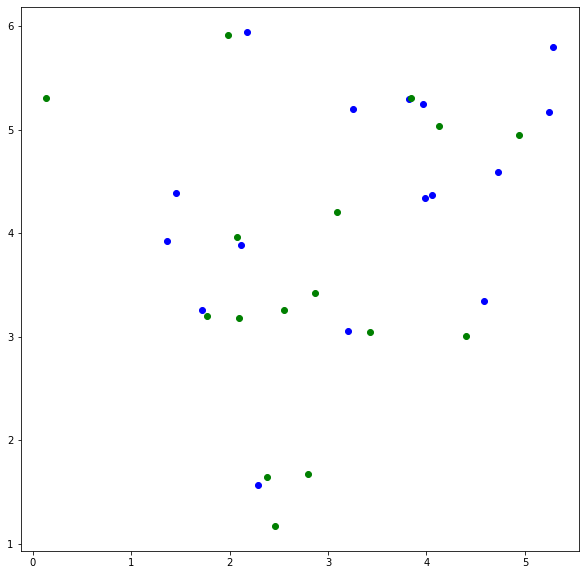

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(sel_data[:16, 0], sel_data[:16, 1], c='b')
ax.scatter(sel_data[16:, 0], sel_data[16:, 1], c='g')

In [19]:
np.savetxt('./experiment_data/bank/sel_data_32.txt', sel_data)

In [84]:
num_qubits = 4

sel_data = np.genfromtxt('./experiment_data/bank/sel_data_32.txt')

start = time.time()

for i in range(1):
    curr_mats = []
    
    curr_dir = './experiment_data/bank/trained_circuits/circ_{}'.format(i + 1)
    
    if os.path.exists(curr_dir + '/fid_mats'):
        pass
    else:
        os.mkdir(curr_dir + '/fid_mats')
    
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir)  
    
    for j in range(1):
        curr_params = 2 * np.pi * np.random.sample(weights_bounds[-1])
        curr_params = np.concatenate([curr_params for i in range(32)]).reshape((32, weights_bounds[-1]))
        
        curr_fids = compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, curr_params, sel_data)
        print(curr_fids)
#         np.savetxt(curr_dir + '/fid_mats/init_mat_1_{}.txt'.format(j), curr_fids)
        
    print(i)
    
end = time.time()

TypeError: RX_PI(): incompatible function arguments. The following argument types are supported:
    1. (self: pennylane_lightning.lightning_qubit_ops.StateVectorC128, arg0: List[int], arg1: bool, arg2: List[float]) -> None

Invoked with: <pennylane_lightning.lightning_qubit_ops.StateVectorC128 object at 0x7fc95ba66eb0>, [0], False, [array([5.89843014, 1.85267838, 2.85413322, 1.47579682, 4.40527825,
       5.6282525 , 5.57209351, 4.3879019 , 2.91995771, 1.58270575,
       0.85163768, 1.96368002])]

In [ ]:
(end - start) / 1000

Text(0.5, 1.0, 'KendalltauResult(correlation=0.3552808950699737, pvalue=6.437965466889393e-94)')

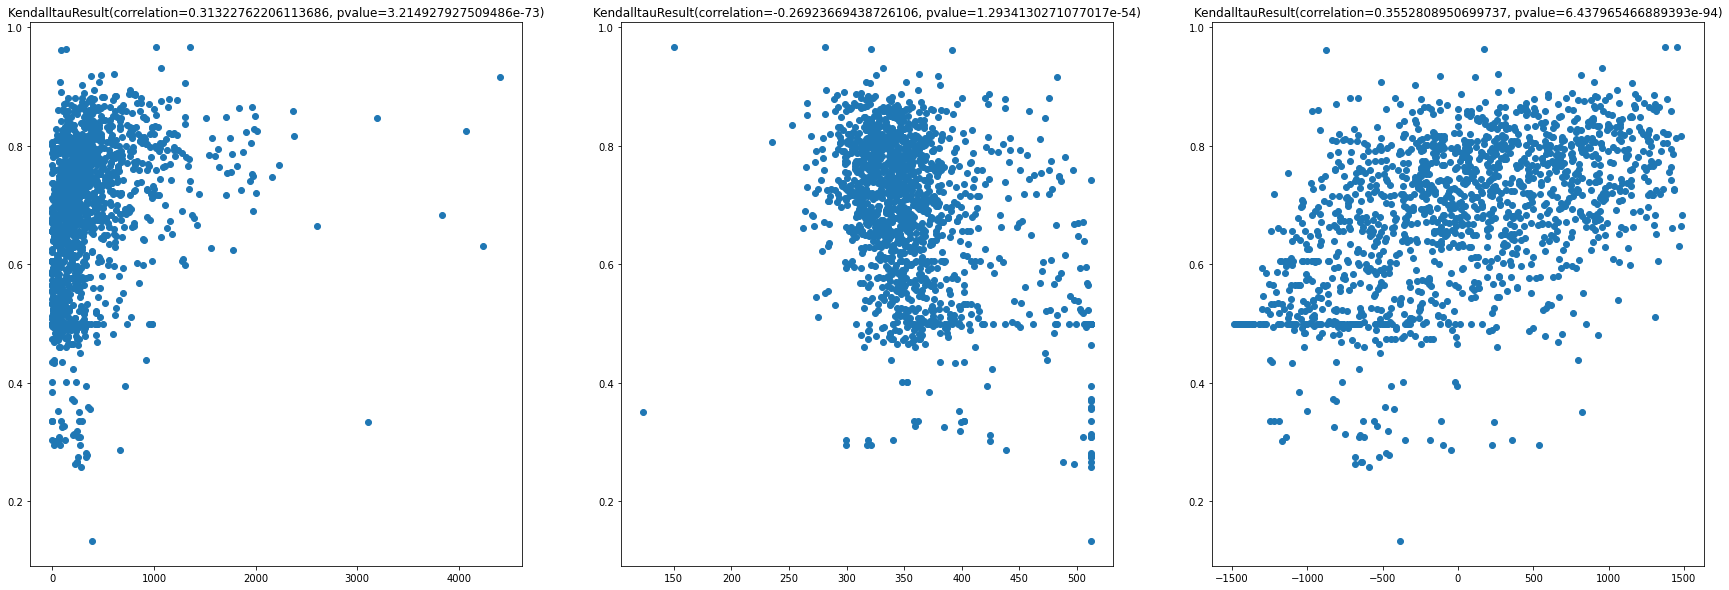

In [325]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

best_accs = np.array(best_accs)
old_accs = np.array(old_accs)

v_t_scores = np.array(v_t_scores)
mean_scores = np.array(mean_scores)
min_scores = np.array(min_scores)

good_inds = np.argwhere(best_accs >= 0.1).flatten()

ax[0].scatter(v_t_scores, old_accs)
ax[0].set_title(scipy.stats.kendalltau(v_t_scores, old_accs))

ax[1].scatter(mean_scores, old_accs)
ax[1].set_title(scipy.stats.kendalltau(mean_scores, old_accs))

ax[2].scatter(ranks, old_accs)
ax[2].set_title(scipy.stats.kendalltau(ranks, old_accs))


# ax[0, 0].scatter(mean_scores[inds][good_inds], old_accs[good_inds])
# ax[0, 0].set_title(scipy.stats.kendalltau(mean_scores[inds][good_inds], old_accs[good_inds]))

# ax[1, 0].scatter(min_scores[inds][good_inds], best_accs[good_inds])
# ax[1, 0].set_title(scipy.stats.kendalltau(min_scores[inds][good_inds], best_accs[good_inds]))

# ax[0, 1].scatter(v_t_scores[inds][good_inds], best_accs[good_inds])
# ax[0, 1].set_title(scipy.stats.kendalltau(v_t_scores[inds][good_inds], best_accs[good_inds]))

# ax[1, 1].scatter(ranks[inds][good_inds], best_accs[good_inds])
# ax[1, 1].set_title(scipy.stats.kendalltau(ranks[inds][good_inds], best_accs[good_inds]))

In [126]:
x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')[:, :2]
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')[:, :2]
y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 2 * y_train - 1
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 2 * y_test - 1

num_qubits = 2
# num_embeds = 16
# num_params = 18


# ent_prob = np.random.sample()
# cxz = np.random.sample()
# pauli = np.random.sample()

dev = qml.device('lightning.qubit', wires=num_qubits)

# circ_gates, gate_params, inputs_bounds, weights_bounds = generate_random_gate_circ(num_qubits, num_embeds, num_params, 
#                                                                                                 ent_prob=ent_prob, 
#                                                                                                 cxz_prob=cxz * ent_prob,
#                                                                                                 pauli_prob=pauli * (
#                                                                                                     1 - cxz) * ent_prob)

# circ = create_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
#                                                 weights_bounds, [0, 1], 'exp', 'adjoint')  

circ_list = [human_design_1_moons, human_design_2_moons, human_design_3_moons, human_design_4_moons]
weight_shapes_list = [(5, 1, 2), (2, 1, 2, 3), (2, 1, 2, 3), (5, 1, 2)]
circ_descs = [
    'angle embedding, basic ent layer * 2 (rx, rz), angle embedding, basic ent layer * 3 (rx, rz, ry)',
    'angle embedding, strong ent  layer, angle embedding, strong ent layer',
    'iqp embedding, strong ent layer, iqp embedding, strong ent layer',
    'iqp embedding, basic ent layer * 2 (rx, rz), iqp embedding, basic ent layyer * 3 (rx, rz, ry)'
]

for i in range(1, 4):
    circ_dir = './human_design/moons_300/circ_{}'.format(i + 1)
    
    if not os.path.exists(circ_dir):
        os.mkdir(circ_dir)
        
    np.savetxt(circ_dir + '/circ_desc.txt', [circ_descs[i]], fmt="%s")
    
    circ = qml.QNode(circ_list[i], dev, interface='tf', diff_method='adjoint')

    losses_list = []
    accs_list = []
    
    for j in range(5):
        curr_train_dir = circ_dir + '/run_{}'.format(j + 1)

        if os.path.exists(curr_train_dir):
            pass
        else:
            os.mkdir(curr_train_dir)

        info = train_qnn(circ, x_train, y_train, x_test, y_test, weight_shapes_list[i], 2400, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                                    loss_window=50, init_params=None, 
                                                                                                    acc_thres=1.1, shuffle=True, print_loss=50)
        
        val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
        val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

        acc = np.sum(val_loss < 1) / len(x_test)
        
        np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), [k.flatten() for k in info[-1]])
        np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])
        
        losses_list.append(val_loss)
        accs_list.append(acc)
        
    np.savetxt(circ_dir + '/val_losses.txt', losses_list)
    np.savetxt(circ_dir + '/accs.txt', accs_list)

Step 1 | Sliding Loss Window : 0.24992990122160127
Step 51 | Sliding Loss Window : 1.0114203788587246
Step 101 | Sliding Loss Window : 0.7828757180122409
Step 151 | Sliding Loss Window : 0.8118412139985189
Step 201 | Sliding Loss Window : 0.9877597331906618
Step 251 | Sliding Loss Window : 0.7082582521021209
Step 301 | Sliding Loss Window : 0.9486918302057293
Step 351 | Sliding Loss Window : 0.8645347058186205
Step 401 | Sliding Loss Window : 0.9362803228222881
Step 451 | Sliding Loss Window : 0.9356028395967085
Step 501 | Sliding Loss Window : 0.876509466950705
Step 551 | Sliding Loss Window : 0.8979356441753662
Step 601 | Sliding Loss Window : 0.6850396736602866
Step 651 | Sliding Loss Window : 0.9012121248802533
Step 701 | Sliding Loss Window : 0.9331512802307919
Step 751 | Sliding Loss Window : 0.7545474104925433
Step 801 | Sliding Loss Window : 0.7708686518405505
Step 851 | Sliding Loss Window : 1.0153251998185457
Step 901 | Sliding Loss Window : 0.9324162680637964
Step 951 | Slid

In [212]:
ind = 3
best_runs = [4, 4, 3, 3]

# curr_dir = './experiment_data/bank/trained_circuits/circ_{}'.format(i + 1)
curr_dir = './experiment_data/moons_300/trained_circuits/circ_45'
    
circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

circ = create_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                                    weights_bounds, [0], 'exp')   

params = np.genfromtxt(curr_dir + '/params_1.txt')[-1]

# circ = qml.QNode(circ_list[ind], dev, interface='tf', diff_method='adjoint')
# params = np.genfromtxt('./human_design/moons_300/circ_{}/run_{}/params_{}.txt'.format(ind + 1, best_runs[ind], best_runs[ind]))[-1].reshape(weight_shapes_list[ind])

accs = []

for i in range(len(x_test)):
    accs.append(np.sum(np.multiply(-1 * y_test[i], circ(np.concatenate((x_test[i], x_test[i])), params).numpy()) > 0) == 1)
        
np.sum(accs) / len(x_test), np.sum(accs[:60]), np.sum(accs[60:])

(0.95, 56, 58)

In [ ]:
points = np.linspace(0, 2 * np.pi, 100)

points = list(product(points, points))
points = np.array(points)
points = np.concatenate((points, points), 1)

preds = [circ(point, params).numpy().item() for point in points]

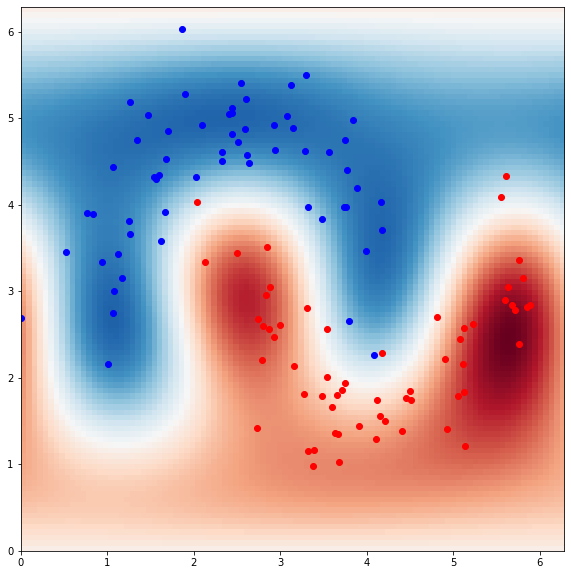

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(-1 * np.array(preds).reshape((100, 100)).T[:, ::-1], vmin=-1, vmax=1, cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])
ax.scatter(x_test[:, 0][:60], x_test[:, 1][:60], c='b')
ax.scatter(x_test[:, 0][60:], x_test[:, 1][60:], c='r')
# ax.set_title('Human designed circuit {} | Acc: {}'.format(ind, np.sum(accs) / len(x_test)))

In [193]:
accs = []
accs_moons = []
accs_bank = []

gates = []
gates_moons = []
gates_bank = []

for i in range(100):          
    curr_dir = './experiment_data/mnist_2/trained_circuits/circ_{}'.format(i + 1)
    
    if os.path.exists(curr_dir + '/accs.txt'):
        curr_losses = np.mean(np.genfromtxt(curr_dir + '/accs.txt'))
        accs.append(curr_losses)
        
#         gates.append(len(np.genfromtxt(curr_dir + '/gates.txt')))
        
    curr_dir = './experiment_data/bank/trained_circuits/circ_{}'.format(i + 1)
    
    if os.path.exists(curr_dir + '/accs.txt') or os.path.exists(curr_dir + '/accs_2.txt'):
        if os.path.exists(curr_dir + '/accs_2.txt'):
            curr_losses = np.mean(np.genfromtxt(curr_dir + '/accs_2.txt'))
        else:
            curr_losses = np.mean(np.genfromtxt(curr_dir + '/accs.txt'))
        accs_bank.append(curr_losses)
    else:
        print(i)
        
#         gates_bank.append(len(np.genfromtxt(curr_dir + '/gates.txt')))
           
            
    curr_dir = './experiment_data/moons_300/trained_circuits/circ_{}'.format(i + 1)
    
    if os.path.exists(curr_dir + '/accs.txt'):
        curr_losses = np.mean(np.genfromtxt(curr_dir + '/accs.txt'))
        accs_moons.append(curr_losses)
        
#         gates_moons.append(len(np.genfromtxt(curr_dir + '/gates.txt')))
    
len(accs)

100

In [208]:
np.argsort(accs_moons)[-10:]

array([48,  1, 46, 51, 42,  4,  0, 44, 53, 60])

In [494]:
len(accs), len(accs_moons), len(accs_bank)

(999, 4288, 3860)

(array([108.,   6.,   1.,   8.,   5.,   7.,   8.,   1.,   6.,  10.,   7.,
          2.,   5.,   9.,   2.,   6.,   3.,   5.,   7.,   0.,   6.,   6.,
          6.,   3.,   8.,   4.,  14.,   7.,   4.,   4.,   8.,   6.,   5.,
          6.,   4.,   3.,   5.,   9.,   6.,   6.,   7.,   8.,  24.,   4.,
          6.,   3.,   6.,   4.,   7.,   6.,   7.,   8.,   7.,   7.,   6.,
          9.,  12.,   8.,   5.,  13.,  12.,   8.,  24.,   8.,  11.,  11.,
         11.,  12.,  18.,  14.,   8.,  17.,  13.,  17.,  12.,   6.,  11.,
         15.,  12.,  18.,   7.,  18.,   9.,   9.,  14.,  19.,  16.,  18.,
         18.,  16.,  19.,  15.,  16.,  18.,  17.,  26.,  26.,  16.,  17.,
         11.,  17.,  23.,  19.,  23.,  19.,  24.,  31.,  17.,  27.,  19.,
         20.,  24.,  20.,  24.,  29.,  33.,  25.,  30.,  37.,  31.,  40.,
         27.,  28.,  36.,  39.,  40.,  31.,  38.,  32.,  42.,  31.,  38.,
         36.,  42.,  42.,  45.,  35.,  43.,  38.,  45.,  51.,  42.,  57.,
         44.,  36.,  50.,  54.,  54., 

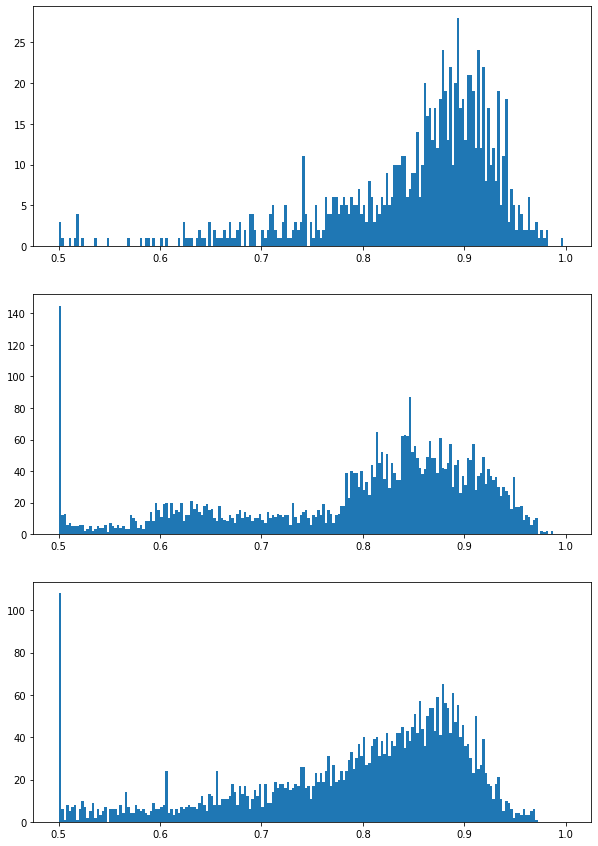

In [495]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].hist(accs, bins=[0.0025 * i for i in range(200, 401)])
# ax[0].set_xscale('log')
# ax[0].set_xlim([np.sort(gates)[len(gates) // 10], np.sort(gates)[-1 * len(gates) // 10]])
ax[1].hist(accs_moons, bins=[0.0025 * i for i in range(200, 401)])
# ax[1].set_xscale('log')
# ax[1].set_xlim([np.sort(gates_moons)[len(gates_moons) // 10], np.sort(gates_moons)[-1 * len(gates_moons) // 10]])
ax[2].hist(accs_bank, bins=[0.0025 * i for i in range(200, 401)])
# ax[2].set_xscale('log')
# ax[2].set_xlim([np.sort(gates_bank)[len(gates_bank) // 10], np.sort(gates_bank)[-1 * len(gates_bank) // 10]])
# ax.set_xscale('log')


In [272]:
num_qubits = 12
num_embeds = 32
num_params = 40

ent_prob = np.random.sample()
cxz = np.random.sample()
pauli = np.random.sample()

circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                ent_prob=ent_prob, 
                                                                                                cxz_prob=cxz * ent_prob,
                                                                                                pauli_prob=pauli * (
                                                                                                    1 - cxz) * ent_prob)

dev = qml.device('lightning.qubit', wires=num_qubits)

circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                weights_bounds, [0], 'exp', 'adjoint') 

x = np.random.sample(32)
w = tf.Variable(np.random.sample(40))

with tf.GradientTape() as tape:
    out = circ(x, w)
    
print(tape.gradient(out, w))

tf.Tensor(
[-5.99360944e-17 -8.49135195e-18 -3.09907996e-03  2.59988204e-03
  1.70809417e-02 -1.79605895e-02  2.39027337e-02 -8.95323702e-02
 -1.03153688e-02  1.22119479e-02  6.47930741e-03 -1.13853382e-02
 -9.36647302e-02  1.89619068e-02 -6.54570212e-02 -1.22996083e-02
 -1.51862535e-02  1.15561289e-02  1.24834515e-02 -9.88293406e-03
 -6.40415852e-03 -1.21295118e-17  1.41873356e-02  9.36508173e-03
  2.56128134e-02  3.42628644e-04 -1.69752826e-02 -3.12714996e-02
 -2.65739515e-02 -7.63799314e-02 -1.14476503e-17  7.38273917e-18
 -5.06169949e-17 -4.63835242e-18  1.13835924e-03 -2.21312768e-17
 -7.18851350e-02  2.37169225e-19  0.00000000e+00  0.00000000e+00], shape=(40,), dtype=float64)


In [259]:
dev = qml.device("lightning.qubit", wires=2, shots=None)

@qml.batch_params(all_operations=True)
@qml.qnode(dev, diff_method=None, interface=None)
def circuit(inputs, weights):
#     qml.AngleEmbedding(inputs, wires = range(16), rotation="Y")    
    
    for j in range(2):
        for i in range(2):
            qml.CNOT(wires=[i, (i + 1) % 2])    

        for i in range(2):
            qml.RX(weights[:, 2 * j + i], wires=i % 2)
            qml.RZ(inputs[:, 2 * j + i], wires=i % 2)
        
    return qml.density_matrix(0)



# circ = qml.QNode(circuit, dev, diff_method='adjoint', interface=None)
# b_circ = qml.batch_input(circ, argnum=0)
# bp_circ = qml.batch_params(b_circ, argnum=1)

x = np.random.sample((1024, 4))
w = np.random.sample((1024, 4))

start = time.time()

out = np.array(circuit(x, w))

end = time.time()

print(end - start)

1.4699695110321045


In [264]:
num_qubits = 12
num_embeds = 12
num_params = 12

ent_prob = np.random.sample()
cxz = np.random.sample()
pauli = np.random.sample()

circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                ent_prob=ent_prob, 
                                                                                                cxz_prob=cxz * ent_prob,
                                                                                                pauli_prob=pauli * (
                                                                                                    1 - cxz) * ent_prob)

dev = qml.device('lightning.qubit', wires=num_qubits)

circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                weights_bounds, [0], 'exp', 'adjoint') 

tf.keras.backend.set_floatx('float64') 

ql = qml.qnn.KerasLayer(circ, weight_shapes={'weights': num_params}, output_dim=1)

x = np.random.sample((num_embeds))
w = tf.Variable(np.random.sample(num_params))

with tf.GradientTape() as tape:
    out = ql(x)

tape.gradient(out, ql.variables)

[<tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([ 2.75435889e-17, -9.47912835e-18,  5.41614944e-17, -7.97798486e-18,
         4.40346834e-17,  5.05470867e-17, -3.93322399e-17,  9.10689517e-18,
         2.26353500e-02,  1.34321824e-17, -6.70909583e-17,  7.39241087e-03])>]

## Train supercircuit selected circuits

In [688]:
sc_circs = np.genfromtxt('./supernet/moons/nas_result_sorted.txt', dtype=str)

circ_layers = [[int(j) for j in i[0].split('-')] for i in sc_circs]
circ_accs = [float(i[1]) for i in sc_circs]

layer_gates = [i[1:].split(')') for i in open('./supernet/moons/search_space.txt').read().split('\n')][:-1]

layer_rots = [''.join([j for j in i[0] if j.isupper()]) for i in layer_gates]
layer_rots = [[i[j * 2:j * 2 + 2].lower() for j in range(len(i) // 2)] for i in layer_rots]

layer_cnots = [''.join([j for j in i[1][1:] if j not in ['[', ']', ',', ' ']]) for i in layer_gates]
layer_cnots = [[[int(i[2 * j]), int(i[2 * j + 1])] for j in range(len(i) // 2)] for i in layer_cnots]

In [689]:
def convert_supernet_circ_into_gate_circ(subnet, num_embeds, layer_rots, layer_cnots, num_qubits):
    circ_gates = []
    gate_params = []
    weights_bounds = [0]
    inputs_bounds = [0]

    curr_layers = subnet
    
    for i in range(1):
        num_qubits = len(layer_rots[0])

        for j in range(num_embeds):
            circ_gates += ['h' for i in range(num_qubits)] + ['ry' for i in range(num_qubits)] + ['cry' for i in range(num_qubits - 1)]
            gate_params += [[i] for i in range(num_qubits)] * 2 + [[i, i + 1] for i in range(num_qubits - 1)]
            weights_bounds += [0 for i in range(3 * num_qubits - 1)]
            inputs_bounds += [inputs_bounds[-1] for i in range(num_qubits)] + [inputs_bounds[-1] + i + 1 for i in range(2 * num_qubits - 1)]

        for j in range(len(curr_layers)):
            circ_gates += layer_rots[curr_layers[j]]
            circ_gates += ['cx' for k in layer_cnots[curr_layers[j]]]

            gate_params += [[k] for k in range(len(layer_rots[curr_layers[j]]))]
            gate_params += layer_cnots[curr_layers[j]]

            weights_bounds += [weights_bounds[-1] + k + 1 for k in range(num_qubits)]
            inputs_bounds += [inputs_bounds[-1] for k in range(num_qubits)]

            weights_bounds += [weights_bounds[-1] for k in range(len(layer_cnots[curr_layers[j]]))]
            inputs_bounds += [inputs_bounds[-1] for k in range(len(layer_cnots[curr_layers[j]]))]
            
    return circ_gates, gate_params, inputs_bounds, weights_bounds

In [ ]:
x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')[:, :2]
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')[:, :2]

p_1 = np.prod(x_train[:, :2], 1).reshape((len(x_train), 1))
# p_2 = np.prod(x_train[:, 4:8], 1).reshape((len(x_train), 1))
# p_3 = np.prod(x_train[:, 8:12], 1).reshape((len(x_train), 1))
# p_4 = np.prod(x_train[:, 12:], 1).reshape((len(x_train), 1))

x_train = np.concatenate((x_train[:, :2], p_1), 1)

p_1 = np.prod(x_test[:, :2], 1).reshape((len(x_test), 1))
# p_2 = np.prod(x_test[:, 4:8], 1).reshape((len(x_test), 1))
# p_3 = np.prod(x_test[:, 8:12], 1).reshape((len(x_test), 1))
# p_4 = np.prod(x_test[:, 12:], 1).reshape((len(x_test), 1))

x_test = np.concatenate((x_test[:, :2], p_1), 1)

y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 1 - 2 * y_test

num_qubits = 2
num_cnot_configs = 4

dev = qml.device('lightning.qubit', wires=num_qubits)

param_nums = [2, 4, 6, 8, 10, 12, 14, 16]

for p in param_nums:
    supernet_dir = './supernet/moons/search-{}_params'.format(p)

    num_layers = p // num_qubits
    search_space = len(open(supernet_dir + '/search_space.txt').read().split('\n')) - 1

    accs = []
    circ_layers = []

    params = np.genfromtxt(supernet_dir + '/training_params.txt')[-1].reshape((num_layers, search_space // num_cnot_configs, num_qubits))

    for i in range(500):
        curr_circ_desc = np.random.randint(0, search_space, num_layers)

        curr_params = np.concatenate([params[k, curr_circ_desc[k] // num_cnot_configs] for k in range(num_layers)]).flatten()
        acc = 0

        circ_gates, gate_params, inputs_bounds, weights_bounds = convert_supernet_circ_into_gate_circ(curr_circ_desc, 1, layer_rots, layer_cnots, num_qubits) 

        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                            weights_bounds, [0], 'exp', 'adjoint') 
        
        for j in range(len(x_test)):
            acc += 1 if y_test[j] * circ(x_test[j], curr_params) > 0 else 0

        acc /= len(x_test)
        
        print(acc)

        accs.append(acc)
        circ_layers.append(curr_circ_desc)

    np.savetxt(supernet_dir + '/searched_circ_accs.txt', ['{} {}'.format(circ_layers[i], accs[i]) for i in range(500)], fmt="%s")

0.525
0.725
0.25833333333333336
0.31666666666666665
0.75
0.75
0.25
0.7666666666666667
0.7416666666666667
0.30833333333333335
0.25
0.7416666666666667
0.7416666666666667
0.31666666666666665
0.7416666666666667
0.7416666666666667
0.7416666666666667
0.75
0.4
0.7416666666666667
0.525
0.7416666666666667
0.525
0.4666666666666667
0.725
0.31666666666666665
0.7666666666666667
0.7416666666666667
0.7416666666666667
0.725
0.725
0.7666666666666667
0.7416666666666667
0.7416666666666667
0.4
0.4666666666666667
0.25
0.25
0.7666666666666667
0.7416666666666667
0.25
0.4
0.25
0.7666666666666667
0.7416666666666667
0.7416666666666667
0.7416666666666667
0.725
0.25833333333333336
0.725
0.7416666666666667
0.31666666666666665
0.7416666666666667
0.725
0.25
0.7416666666666667
0.725
0.4
0.525
0.7666666666666667
0.25
0.25
0.4
0.31666666666666665
0.75
0.525
0.25
0.25
0.25
0.7416666666666667
0.25
0.725
0.725
0.25
0.725
0.25
0.7666666666666667
0.475
0.7416666666666667
0.25
0.7416666666666667
0.475
0.7416666666666667
0.74

In [446]:
layer_rots[0]

['rx', 'rx', 'rx', 'rx']

In [ ]:
x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')[:, :2]
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')[:, :2]

extra_embed_train = np.ones((len(x_train), 1))
extra_embed_test = np.ones((len(x_test), 1))

for i in range(len(x_train[0])):
    extra_embed_train *= (np.pi - x_train[:, i]).reshape((len(x_train), 1))
    extra_embed_test *= (np.pi - x_test[:, i]).reshape((len(x_test), 1))

x_train = np.concatenate((x_train, extra_embed_train), 1)
x_train = np.concatenate((x_train, x_train), 1)
x_test = np.concatenate((x_test, extra_embed_test), 1)
x_test = np.concatenate((x_test, x_test), 1)

y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 1 - 2 * y_test

num_qubits = 2

dev = qml.device('lightning.qubit', wires=num_qubits)

search_nums = [10, 25, 50, 100, 250]

circ_layers = np.array(circ_layers)
circ_accs = np.array(circ_accs)


for k in range(len(search_nums)):
    search_dir = './supernet/moons/search_{}'.format(search_nums[k])

    if not os.path.exists(search_dir):
        os.mkdir(search_dir)
    
    for i in range(5):
        curr_dir = './supernet/moons/search_{}/trial_{}'.format(search_nums[k], i + 1)

        if not os.path.exists(curr_dir):
            os.mkdir(curr_dir)

        chosen_circs = np.random.choice(1000, search_nums[k], False)
        best_subnet = circ_layers[chosen_circs[np.argmax(circ_accs[chosen_circs])]]
        
        np.savetxt(curr_dir + '/searched_circuits.txt', circ_layers[chosen_circs])
        np.savetxt(curr_dir + '/searched_circuit_accs.txt', circ_accs[chosen_circs])

        circ_gates, gate_params, inputs_bounds, weights_bounds = convert_supernet_circ_into_gate_circ(best_subnet, 2, layer_rots, layer_cnots, num_qubits)
    
        

        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0], 'exp', 'adjoint') 

        losses_list = []
        accs_list = []

        for j in range(5):
            curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)


            info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 2400, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(val_loss < 1)

            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_dir + '/accs.txt', accs_list)
        np.savetxt(curr_dir + '/val_losses.txt', losses_list)            

        np.savetxt(curr_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_dir + '/weights_bounds.txt', weights_bounds)
        np.savetxt(curr_dir + '/layers.txt', best_subnet)

Step 1 | Sliding Loss Window : 0.18202551623350885
Step 51 | Sliding Loss Window : 1.1418404675715754
Step 101 | Sliding Loss Window : 1.0038385726655639
Step 151 | Sliding Loss Window : 1.0160207964052697
Step 201 | Sliding Loss Window : 0.9181087370527916
Step 251 | Sliding Loss Window : 0.9413718761039918
Step 301 | Sliding Loss Window : 0.9022529254829521
Step 351 | Sliding Loss Window : 0.9230618063748254
Step 401 | Sliding Loss Window : 0.8601724882754569
Step 451 | Sliding Loss Window : 0.7313055938507795
Step 501 | Sliding Loss Window : 0.8813670325136955
Step 551 | Sliding Loss Window : 0.8989298766278389
Step 601 | Sliding Loss Window : 0.843986014134694
Step 651 | Sliding Loss Window : 0.9311416638967419
Step 701 | Sliding Loss Window : 0.8700371213429223
Step 751 | Sliding Loss Window : 0.9091841542898872
Step 801 | Sliding Loss Window : 0.8528326955334238


In [423]:
search_nums = [10, 25, 50, 100, 250]

for k in range(4, 5):
    search_dir = './supernet/moons/search_{}'.format(search_nums[k])

    if not os.path.exists(search_dir):
        os.mkdir(search_dir)
    
    for i in range(4, 5):
        curr_dir = './supernet/moons/search_{}/trial_{}'.format(search_nums[k], i + 1)

        circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir)        
        
        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0], 'exp', 'adjoint')         

        info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 2400, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

Step 1 | Sliding Loss Window : 0.32266449779309797
Step 51 | Sliding Loss Window : 1.0589861088344497
Step 101 | Sliding Loss Window : 0.8148028676353972
Step 151 | Sliding Loss Window : 0.9599586501450239
Step 201 | Sliding Loss Window : 0.9735235453401863
Step 251 | Sliding Loss Window : 0.9801171729383761
Step 301 | Sliding Loss Window : 0.8644718263837943
Step 351 | Sliding Loss Window : 0.926344649175887
Step 401 | Sliding Loss Window : 1.1177394752503154
Step 451 | Sliding Loss Window : 0.912024951212983
Step 501 | Sliding Loss Window : 0.7390535174971788
Step 551 | Sliding Loss Window : 0.7419543764884
Step 601 | Sliding Loss Window : 0.7438097921074366
Step 651 | Sliding Loss Window : 0.9862423031511078
Step 701 | Sliding Loss Window : 0.9080859272795138
Step 751 | Sliding Loss Window : 0.8492080655415394
Step 801 | Sliding Loss Window : 0.9578815842061837
Step 851 | Sliding Loss Window : 1.0081755623558648
Step 901 | Sliding Loss Window : 0.9060989158003646
Step 951 | Sliding 

In [419]:
circ_list = []
params_list = []

for i in range(len(search_nums)):
    for j in range(5):
        curr_dir = './supernet/moons/search_{}/trial_{}'.format(search_nums[i], j + 1)
        
        circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir)        
        
        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0], 'exp', 'adjoint') 
        
        accs_list = []
        losses_list = []
        
        circ_list.append(circ)
        circ_params = []
        
        for k in range(5):
            curr_run_dir = curr_dir + '/run_{}'.format(k + 1)
            
            params = np.genfromtxt(curr_run_dir + '/params_{}.txt'.format(k + 1))[-1]
            circ_params.append(params)

            val_exps = [circ(x_test[i], params) for i in range(len(x_test))]
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(val_loss < 1)
            
            losses_list.append(val_loss)
            accs_list.append(acc)
            
        np.savetxt(curr_dir + '/accs.txt', accs_list)
        np.savetxt(curr_dir + '/val_losses.txt', losses_list)
        params_list.append(circ_params)

In [477]:
test_accs = []
pred_accs = []

for i in range(len(search_nums)):
    for j in range(5):
        curr_dir = './supernet/moons/search_{}/trial_{}'.format(search_nums[i], j + 1)
            
        test_accs.append(np.mean(np.genfromtxt(curr_dir + '/accs.txt')))
#         test_losses.append(np.mean(np.genfromtxt(curr_dir + '/val_losses_all.txt')))
        pred_accs.append(np.max(np.genfromtxt(curr_dir + '/searched_circuit_accs.txt')))

## Train randomly generate circuits

In [ ]:
x_train = np.genfromtxt('./experiment_data/fmnist_4/x_train.txt')
x_test = np.genfromtxt('./experiment_data/fmnist_4/x_test.txt')

y_train = np.genfromtxt('./experiment_data/fmnist_4/y_train.txt')
# y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/fmnist_4/y_test.txt')
# y_test = 1 - 2 * y_test

num_params = [10, 12, 14, 16, 18, 20, 22, 24]

num_qubits = 4
num_embeds = 16

dev = qml.device('lightning.qubit', wires=num_qubits)

for curr_num_params in num_params:
    curr_dir = './random/fmnist_4/{}_params'.format(curr_num_params)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
        
    for i in range(5):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)
        
        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, curr_num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
#         circ_gates = ['h'] * num_qubits + ['rz'] * num_qubits + ['zz'] * (num_qubits - 1) + circ_gates
#         gate_params = [[i] for i in range(num_qubits)] * 2 + [[i, i + 1] for i in range(num_qubits - 1)] + gate_params
#         weights_bounds = [0] * (3 * num_qubits - 1) + weights_bounds
#         inputs_bounds = [0] * (num_qubits + 1) + [i + 1 for i in range(num_qubits)] +\
#             [i + num_qubits + 1 for i in range(num_qubits - 1)] + [2 * num_qubits - 1 for l in range(len(inputs_bounds) - 1)]
        
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
        
        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0, 1], 'exp', 'adjoint') 

        losses_list = []
        accs_list = []
        
        for j in range(5):
            curr_train_dir = curr_circ_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)
                        
            info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 16000, 0.05, 1, mse_vec_loss, verbosity=17300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
            val_loss = np.array([mse_vec_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(np.sum(np.multiply(val_exps, y_test) > 0, 1) == 2)

            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_circ_dir + '/accs.txt', accs_list)
        np.savetxt(curr_circ_dir + '/val_losses.txt', losses_list)   

Step 1 | Sliding Loss Window : 0.9901781921048108
Step 51 | Sliding Loss Window : 1.6025026033443581
Step 101 | Sliding Loss Window : 1.5569717934704683
Step 151 | Sliding Loss Window : 1.4230610952068752
Step 201 | Sliding Loss Window : 1.4156111828278992
Step 251 | Sliding Loss Window : 1.5034359253309584
Step 301 | Sliding Loss Window : 1.4270103282407434
Step 351 | Sliding Loss Window : 1.2834793542560814
Step 401 | Sliding Loss Window : 1.5046650813654567
Step 451 | Sliding Loss Window : 1.2864653963927295
Step 501 | Sliding Loss Window : 1.4550222771673003
Step 551 | Sliding Loss Window : 1.3515820580705797
Step 601 | Sliding Loss Window : 1.557985131163138
Step 651 | Sliding Loss Window : 1.5115669634503803
Step 701 | Sliding Loss Window : 1.4081839900250106
Step 751 | Sliding Loss Window : 1.308755345485568
Step 801 | Sliding Loss Window : 1.340261408133001
Step 851 | Sliding Loss Window : 1.4177071577881608
Step 901 | Sliding Loss Window : 1.4056112025284833
Step 951 | Sliding

## Train human designed circuits

In [ ]:
circ = generate_human_design_circ(dev, 3, 'angle', 'basic', 2, 2, [['X'], ['Y']], [[qml.RX], [qml.RY]], [0])

In [ ]:
x_train = np.genfromtxt('./experiment_data/mnist_2/x_train.txt')[:, :16]
x_test = np.genfromtxt('./experiment_data/mnist_2/x_test.txt')[:, :16]

x_train = x_train.reshape((len(x_train), 4, 4))
x_test = x_test.reshape((len(x_test), 4, 4))

y_train = np.genfromtxt('./experiment_data/mnist_2/y_train.txt')
# y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/mnist_2/y_test.txt')
# y_test = 1 - 2 * y_test

num_params = [12, 24]

num_qubits = 4
num_embed_layers = 2

dev = qml.device('lightning.qubit', wires=num_qubits)

enc_layer_options = [['X'], ['Y']] * 2
var_layer_options = [[None]] * 4

for curr_num_params in num_params:
    curr_dir = './human_design/angle_strong/mnist_2/{}_params'.format(curr_num_params)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
        
    curr_num_layers = curr_num_params // 12
    curr_weights_shape = (curr_num_layers, 1, num_qubits, 3)
        
    for i in range(1):
        curr_circ_dir = curr_dir

        circ = generate_human_design_circ(dev, num_qubits, 'angle', 'strong', 2, curr_num_layers, enc_layer_options, var_layer_options[:curr_num_layers], [0])

#         np.savetxt(curr_circ_dir + '/layers.txt', var_layer_options[:curr_num_layers], fmt="%s")
        
        losses_list = []
        accs_list = []
        
        for j in range(5):
            curr_train_dir = curr_circ_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)
                        
            info = train_qnn(circ, x_train, y_train, x_test, y_test, curr_weights_shape, 5490, 0.05, 1, mse_loss, verbosity=17300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = np.array([circ(x_test[i], info[-1][-1]) for i in range(len(x_test))])
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(val_loss < 1)

            shape = np.array(info[-1]).shape
            
            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), np.array(info[-1]).reshape(shape[0], np.product(shape[1:])))
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_circ_dir + '/accs.txt', accs_list)
        np.savetxt(curr_circ_dir + '/val_losses.txt', losses_list) 

Step 1 | Sliding Loss Window : 2.156480606162906
Step 51 | Sliding Loss Window : 1.0003547307002827
Step 101 | Sliding Loss Window : 0.7598875083992158
Step 151 | Sliding Loss Window : 0.740007769045272
Step 201 | Sliding Loss Window : 0.6276230251721541
Step 251 | Sliding Loss Window : 0.7292631197854063
Step 301 | Sliding Loss Window : 0.5804795397775977
Step 351 | Sliding Loss Window : 0.5814098357980828
Step 401 | Sliding Loss Window : 0.6154163159953383
Step 451 | Sliding Loss Window : 0.6310618855884911
Step 501 | Sliding Loss Window : 0.7537635202167599
Step 551 | Sliding Loss Window : 0.6399485918281463
Step 601 | Sliding Loss Window : 0.6256416108387213
Step 651 | Sliding Loss Window : 0.6865756918572881
Step 701 | Sliding Loss Window : 0.6630805650368292
Step 751 | Sliding Loss Window : 0.6582518665539763
Step 801 | Sliding Loss Window : 0.6356522682748073
Step 851 | Sliding Loss Window : 0.6092639446346783
Step 901 | Sliding Loss Window : 0.5565881656016617
Step 951 | Slidin

## Search for circuits using our method

In [ ]:
search_params = [2, 4, 6, 8, 10, 12, 14, 16]

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal[::-1, :]), 1)

num_qubits = 2
num_embeds = 4

x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')

y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 1 - 2 * y_test

class_0_sel = np.random.choice(240, 16, False)
class_1_sel = np.random.choice(240, 16, False) + 240
sel_inds = np.concatenate((class_0_sel, class_1_sel))

sel_data = x_train[sel_inds]

np.savetxt('./ours/moons/sel_data.txt', sel_data)

dev = qml.device('lightning.qubit', wires=num_qubits)

for p in search_params:
    curr_dir = './ours/moons/{}_params'.format(p)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
    
    d2_min_scores = []
    d2_mean_scores = []
    d2_var_scores = []
    
    d2_t_min_scores = []
    d2_t_mean_scores = []
    d2_t_var_scores = []
    
    for i in range(250):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)

        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        params = 2 * np.pi * np.random.sample((32, p))
        np.savetxt(curr_circ_dir + '/params.txt', params)
        
        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, p, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
    
        circ_d2_scores = []
        circ_d2_t_scores = []
    
        for j in range(32):
            curr_params = np.concatenate([params[j] for k in range(32)]).reshape((32, p))
            mat = compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, curr_params, sel_data)
            
            t_mat = mat > ((np.sum(mat) - 32) / 996)
        
            diff_mat = mat - ideal
            diff_2d = np.sqrt(np.sum(np.multiply(diff_mat, diff_mat)))
            
            diff_t_mat = t_mat - ideal
            diff_2d_t = np.sqrt(np.sum(np.multiply(diff_t_mat, diff_t_mat)))
            
            circ_d2_scores.append(diff_2d)
            circ_d2_t_scores.append(diff_2d_t)
            
        np.savetxt(curr_circ_dir + '/d2_scores.txt', circ_d2_scores)
        np.savetxt(curr_circ_dir + '/d2_t_scores.txt', circ_d2_t_scores)
        
        d2_min_scores.append(np.min(circ_d2_scores))
        d2_mean_scores.append(np.mean(circ_d2_scores))
        d2_var_scores.append(np.var(circ_d2_scores))
        
        d2_t_min_scores.append(np.min(circ_d2_t_scores))
        d2_t_mean_scores.append(np.mean(circ_d2_t_scores))
        d2_t_var_scores.append(np.var(circ_d2_t_scores))
        
    np.savetxt(curr_dir + '/d2_mean_scores.txt', d2_mean_scores)
    np.savetxt(curr_dir + '/d2_min_scores.txt', d2_min_scores)
    np.savetxt(curr_dir + '/d2_var_scores.txt', d2_var_scores)
    
    np.savetxt(curr_dir + '/d2_t_mean_scores.txt', d2_t_mean_scores)
    np.savetxt(curr_dir + '/d2_t_min_scores.txt', d2_t_min_scores)
    np.savetxt(curr_dir + '/d2_t_var_scores.txt', d2_t_var_scores)

In [ ]:
search_params = [12, 16, 20, 24]

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal_2 = np.concatenate((np.zeros((16, 16)), np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal_2, ideal_2[::-1, :], ideal[::-1, :]), 1)

num_qubits = 4
num_embeds = 0

x_train = np.genfromtxt('./experiment_data/fmnist_4/x_train.txt')[:, :16]
x_test = np.genfromtxt('./experiment_data/fmnist_4/x_test.txt')[:, :16]

y_train = np.genfromtxt('./experiment_data/fmnist_4/y_train.txt')
# y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/fmnist_4/y_test.txt')
# y_test = 1 - 2 * y_test

class_0_sel = np.random.choice(2000, 16, False)
class_1_sel = np.random.choice(2000, 16, False) + 2000
class_2_sel = np.random.choice(2000, 16, False) + 4000
class_3_sel = np.random.choice(2000, 16, False) + 6000
sel_inds = np.concatenate((class_0_sel, class_1_sel, class_2_sel, class_3_sel))

sel_data = x_train[sel_inds]

np.savetxt('./ours_fe/fmnist_4/angle_1/sel_data.txt', sel_data)

dev = qml.device('lightning.qubit', wires=num_qubits)

for p in search_params:
    curr_dir = './ours_fe/fmnist_4/angle_1/{}_params'.format(p)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
    
    d2_min_scores = []
    d2_mean_scores = []
    d2_var_scores = []
    
    d2_t_min_scores = []
    d2_t_mean_scores = []
    d2_t_var_scores = []
    
    for i in range(250):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)

        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        params = 2 * np.pi * np.random.sample((32, p))
        np.savetxt(curr_circ_dir + '/params.txt', params)
        
        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, p, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
        circ_gates = ['ry'] * 4 + ['rx'] * 4 + ['rz'] * 4 + ['ry'] * 4 + circ_gates
        gate_params = [[0], [1], [2], [3]] * 4 + gate_params
        inputs_bounds = [k for k in range(17)] + [16 for i in range(len(inputs_bounds) - 1)]
        weights_bounds = [0 for k in range(16)] + weights_bounds
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
    
        circ_d2_scores = []
        circ_d2_t_scores = []
    
        for j in range(32):
            curr_params = np.concatenate([params[j] for k in range(64)]).reshape((64, p))
            mat = compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, curr_params, sel_data, [0, 1])
        
            t_mat = mat > ((np.sum(mat) - 64) / 4032)
        
            diff_mat = mat - ideal
            diff_2d = np.sqrt(np.sum(np.multiply(diff_mat, diff_mat)))
            
            diff_t_mat = t_mat - ideal
            diff_2d_t = np.sqrt(np.sum(np.multiply(diff_t_mat, diff_t_mat)))
            
            circ_d2_scores.append(diff_2d)
            circ_d2_t_scores.append(diff_2d_t)
            
        np.savetxt(curr_circ_dir + '/d2_scores.txt', circ_d2_scores)
        np.savetxt(curr_circ_dir + '/d2_t_scores.txt', circ_d2_t_scores)
        
        d2_min_scores.append(np.min(circ_d2_scores))
        d2_mean_scores.append(np.mean(circ_d2_scores))
        d2_var_scores.append(np.var(circ_d2_scores))
        
        d2_t_min_scores.append(np.min(circ_d2_t_scores))
        d2_t_mean_scores.append(np.mean(circ_d2_t_scores))
        d2_t_var_scores.append(np.var(circ_d2_t_scores))
        
    np.savetxt(curr_dir + '/d2_mean_scores.txt', d2_mean_scores)
    np.savetxt(curr_dir + '/d2_min_scores.txt', d2_min_scores)
    np.savetxt(curr_dir + '/d2_var_scores.txt', d2_var_scores)
    
    np.savetxt(curr_dir + '/d2_t_mean_scores.txt', d2_t_mean_scores)
    np.savetxt(curr_dir + '/d2_t_min_scores.txt', d2_t_min_scores)
    np.savetxt(curr_dir + '/d2_t_var_scores.txt', d2_t_var_scores)

## ours + reduced search space

In [ ]:
search_params = [2, 4, 6, 8, 10, 12, 14, 16]

num_qubits = 2
num_embeds = 4

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal[::-1, :]), 1)

x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')[:, :4]
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')[:, :4]

y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 1 - 2 * y_test

class_0_sel = np.random.choice(240, 16, False)
class_1_sel = np.random.choice(240, 16, False) + 240
sel_inds = np.concatenate((class_0_sel, class_1_sel))

sel_data = x_train[sel_inds]

np.savetxt('./ours_rss/moons/sel_data.txt', sel_data)

dev = qml.device('lightning.qubit', wires=num_qubits)

for p in search_params:
    curr_dir = './ours_rss/moons/{}_params'.format(p)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
    
    d2_min_scores = []
    d2_mean_scores = []
    d2_var_scores = []
    
    d2_t_min_scores = []
    d2_t_mean_scores = []
    d2_t_var_scores = []
    
    for i in range(250):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)

        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        params = 2 * np.pi * np.random.sample((32, p))
        np.savetxt(curr_circ_dir + '/params.txt', params)
        
        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_random_gate_circ(num_qubits, num_embeds, p, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
    
        circ_d2_scores = []
        circ_d2_t_scores = []
    
        for j in range(32):
            curr_params = np.concatenate([params[j] for k in range(32)]).reshape((32, p))
            mat = compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, curr_params, sel_data)
        
            t_mat = mat > ((np.sum(mat) - 32) / 996)
        
            diff_mat = mat - ideal
            diff_2d = np.sqrt(np.sum(np.multiply(diff_mat, diff_mat)))
            
            diff_t_mat = t_mat - ideal
            diff_2d_t = np.sqrt(np.sum(np.multiply(diff_t_mat, diff_t_mat)))
            
            circ_d2_scores.append(diff_2d)
            circ_d2_t_scores.append(diff_2d_t)
            
        np.savetxt(curr_circ_dir + '/d2_scores.txt', circ_d2_scores)
        np.savetxt(curr_circ_dir + '/d2_t_scores.txt', circ_d2_t_scores)
        
        d2_min_scores.append(np.min(circ_d2_scores))
        d2_mean_scores.append(np.mean(circ_d2_scores))
        d2_var_scores.append(np.var(circ_d2_scores))
        
        d2_t_min_scores.append(np.min(circ_d2_t_scores))
        d2_t_mean_scores.append(np.mean(circ_d2_t_scores))
        d2_t_var_scores.append(np.var(circ_d2_t_scores))
        
    np.savetxt(curr_dir + '/d2_mean_scores.txt', d2_mean_scores)
    np.savetxt(curr_dir + '/d2_min_scores.txt', d2_min_scores)
    np.savetxt(curr_dir + '/d2_var_scores.txt', d2_var_scores)
    
    np.savetxt(curr_dir + '/d2_t_mean_scores.txt', d2_t_mean_scores)
    np.savetxt(curr_dir + '/d2_t_min_scores.txt', d2_t_min_scores)
    np.savetxt(curr_dir + '/d2_t_var_scores.txt', d2_t_var_scores)

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Train our method selected circuits

In [ ]:
search_params = [2, 4, 6, 8, 10, 12, 14, 16]

num_qubits = 2
num_embeds = 4

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal[::-1, :]), 1)

x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')[:, :4]
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')[:, :4]

y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 1 - 2 * y_test



Text(0, 0.5, 'Test accuracy')

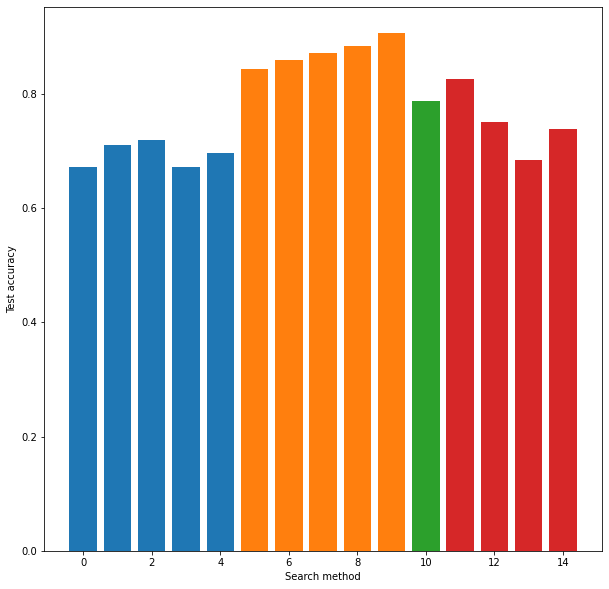

In [487]:
base_count = 480 * 11 * 250
num_circs_run = [base_count + 120 * i for i in [10, 25, 50, 100, 250]]

accs = [np.mean(test_accs[5 * i:5 * i + 5]) for i in range(5)]

our_circs = [10, 25, 50, 100, 250]
our_accs = [0.8425440000000001, 0.8595203333333334, 0.871948, 0.883908, 0.9061939999999998]
    
rand = 0.7879423333333333

human_1 = np.mean(np.genfromtxt('./human_design/moons_300/circ_1/accs.txt'))
human_2 = np.mean(np.genfromtxt('./human_design/moons_300/circ_2/accs.txt'))
human_3 = np.mean(np.genfromtxt('./human_design/moons_300/circ_3/accs.txt'))
human_4 = np.mean(np.genfromtxt('./human_design/moons_300/circ_4/accs.txt'))

all_accs = accs + our_accs + [rand, human_1, human_2, human_3, human_4]

human_accs = [human_1, human_2, human_3, human_4]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.bar(range(5), accs)
ax.bar(range(5, 10), our_accs)
ax.bar(10, rand)
ax.bar(range(11, 15), human_accs)
ax.set_xlabel('Search method')
ax.set_ylabel('Test accuracy')

In [413]:
ind = 5

circ = circ_list[ind]
params = params_list[ind][0]

points = np.linspace(0, 2 * np.pi, 30)

points = list(product(points, points))
points = np.array(points)
points = np.concatenate([points, (np.pi - points[:, 0] * points[:, 1]).reshape(len(points), 1)] * 2, 1)

preds = [circ(point, params).numpy().item() for point in points]

print()

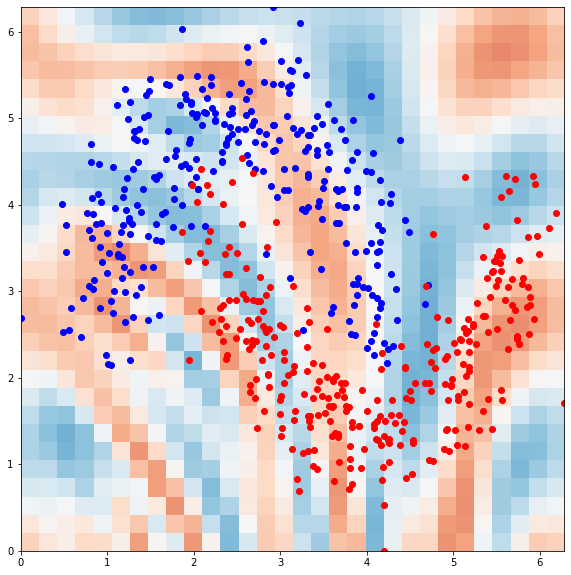

In [415]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(-1 * np.array(preds).reshape((30, 30)).T[:, ::-1], vmin=-1, vmax=1, cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])
# ax.scatter(all_data[:, 0][np.argwhere(all_labels == 1)], all_data[:, 1][np.argwhere(all_labels == 1)], c='b')
# ax.scatter(all_data[:, 0][np.argwhere(all_labels == -1)], all_data[:, 1][np.argwhere(all_labels == -1)], c='r')

In [ ]:
!python supernet/train_search_fmnist_4.py --warmup_epochs 0 --epochs 250 --n_search 100 --n_qubits 4 --n_experts 1 --n_layers 3 --n_encode_layers 4 --save "12_params" --data "./supernet/fmnist_4_data" --save_dir "./supernet/fmnist_4"

2022-07-10 06:49:08.636798: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-07-10 06:49:08.637025: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-07-10 06:49:08.686006: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(8000, 4, 4) (2000, 4, 4)
subnet: [951, 1282, 388], expert_idx: 0
2022-07-10 06:49:11.325220: I tensorflow/core/platform/cpu_feature_guard.cc:142]

In [630]:
s

NameError: name 's' is not defined

## Metric - trainability correlation

### Generate data, train and save circuits

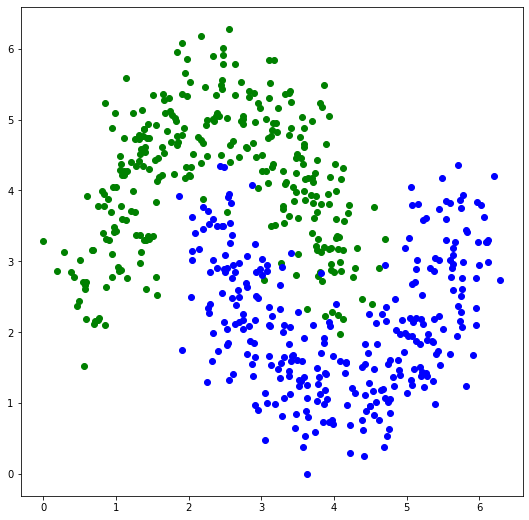

(480, 2) (120, 2) (600, 2) (480, 2) (120, 2)
120.0


In [364]:
ds_name = 'moons_300'
num_samples = 300

x, y = make_moons(2 * num_samples, shuffle=False, noise=0.2)

new_y = np.zeros((2 * num_samples, 2))
new_y[:, 0] = y
new_y[:, 1] = 1 - y

y = new_y
# x = np.genfromtxt('./experiment_data/{}/data.txt'.format(ds_name), delimiter=",")
# y = np.genfromtxt('./experiment_data/{}/labels.txt'.format(ds_name), delimiter=",")
# y = 1 - 2 * y


x[:, 0] -= np.min(x[:, 0])
x[:, 0] *= (2 * np.pi / np.max(x[:, 0]))
x[:, 1] -= np.min(x[:, 1])
x[:, 1] *= (2 * np.pi / np.max(x[:, 1]))

class_0_test_flags = np.random.choice(len(x) // 2, num_samples // 5, False)
class_1_test_flags = np.random.choice(len(x) // 2, num_samples // 5, False) + len(x) // 2

class_0_test_indices = np.zeros(len(x), dtype=bool)
class_0_test_indices[class_0_test_flags] = True
class_1_test_indices = np.zeros(len(x), dtype=bool)
class_1_test_indices[class_1_test_flags] = True

class_0_train_indices = np.ones(len(x), dtype=bool)
class_0_train_indices[class_0_test_flags] = False
class_0_train_indices[len(x) // 2:] = False
class_1_train_indices = np.ones(len(x), dtype=bool)
class_1_train_indices[class_1_test_flags] = False
class_1_train_indices[:len(x) // 2] = False

x_train = np.concatenate((x[class_0_train_indices], x[class_1_train_indices]))
x_test = np.concatenate((x[class_0_test_indices], x[class_1_test_indices]))
y_train = np.concatenate((y[class_0_train_indices], y[class_1_train_indices]))
y_test = np.concatenate((y[class_0_test_indices], y[class_1_test_indices]))

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)

ax.scatter(x[:num_samples, 0], x[:num_samples, 1], c='g')
ax.scatter(x[num_samples:, 0], x[num_samples:, 1], c='b')

plt.show()
print(x_train.shape, x_test.shape, x.shape, y_train.shape, y_test.shape)
print(np.sum(y_test))

# ordering = np.random.permutation(int(1.6 * num_samples))
# x_train = x_train[ordering]
# y_train = y_train[ordering]

In [357]:
np.savetxt('./experiment_data/moons_300/x_train.txt', np.concatenate((x_train, x_train), 1))
np.savetxt('./experiment_data/moons_300/x_test.txt', np.concatenate((x_test, x_test), 1))
np.savetxt('./experiment_data/moons_300/y_train.txt', y_train)
np.savetxt('./experiment_data/moons_300/y_test.txt', y_test)

In [360]:
data = np.genfromtxt('./experiment_data/bank/data.txt', delimiter=',')

labels = data[:, -1]

x = data[:, :-1]

bal_x = np.concatenate((x[labels == 0][:int(np.sum(labels))], x[labels == 1]), 0)
bal_labels = np.concatenate((labels[labels == 0][:int(np.sum(labels))], labels[labels == 1]), 0)

new_labels = np.zeros((len(bal_x), 2))
new_labels[:, 0] = bal_labels
new_labels[:, 1] = 1 - bal_labels
bal_labels = new_labels

for i in range(bal_x.shape[1]):
    bal_x[:, i] -= np.min(bal_x[:, i])
    bal_x[:, i] /= np.max(bal_x[:, i])
    bal_x[:, i] *= 2 * np.pi

num_samples = len(bal_x) // 2

class_0_test_flags = np.random.choice(num_samples, num_samples // 10, False)
class_1_test_flags = np.random.choice(num_samples, num_samples // 10, False) + num_samples

class_0_test_indices = np.zeros(len(bal_x), dtype=bool)
class_0_test_indices[class_0_test_flags] = True
class_1_test_indices = np.zeros(len(bal_x), dtype=bool)
class_1_test_indices[class_1_test_flags] = True

class_0_train_indices = np.ones(len(bal_x), dtype=bool)
class_0_train_indices[class_0_test_flags] = False
class_0_train_indices[len(bal_x) // 2:] = False
class_1_train_indices = np.ones(len(bal_x), dtype=bool)
class_1_train_indices[class_1_test_flags] = False
class_1_train_indices[:len(bal_x) // 2] = False

x_train = np.concatenate((bal_x[class_0_train_indices], bal_x[class_1_train_indices]))
x_test = np.concatenate((bal_x[class_0_test_indices], bal_x[class_1_test_indices]))
y_train = np.concatenate((bal_labels[class_0_train_indices], bal_labels[class_1_train_indices]))
y_test = np.concatenate((bal_labels[class_0_test_indices], bal_labels[class_1_test_indices]))

# y_train = 1 - 2 * y_train
# y_test = 1 - 2 * y_test

plt.show()
print(x_train.shape, x_test.shape, bal_x.shape, y_train.shape, y_test.shape)
print(np.sum(y_train), np.sum(y_test))

ordering = np.random.permutation(int(1.8 * num_samples))
x_train = x_train[ordering]
y_train = y_train[ordering]

(1098, 4) (122, 4) (1220, 4) (1098, 2) (122, 2)
1098.0 122.0


In [361]:
np.savetxt('./experiment_data/bank/x_train.txt', np.concatenate((x_train, x_train), 1))
np.savetxt('./experiment_data/bank/x_test.txt', np.concatenate((x_test, x_test), 1))
np.savetxt('./experiment_data/bank/y_train.txt', y_train)
np.savetxt('./experiment_data/bank/y_test.txt', y_test)

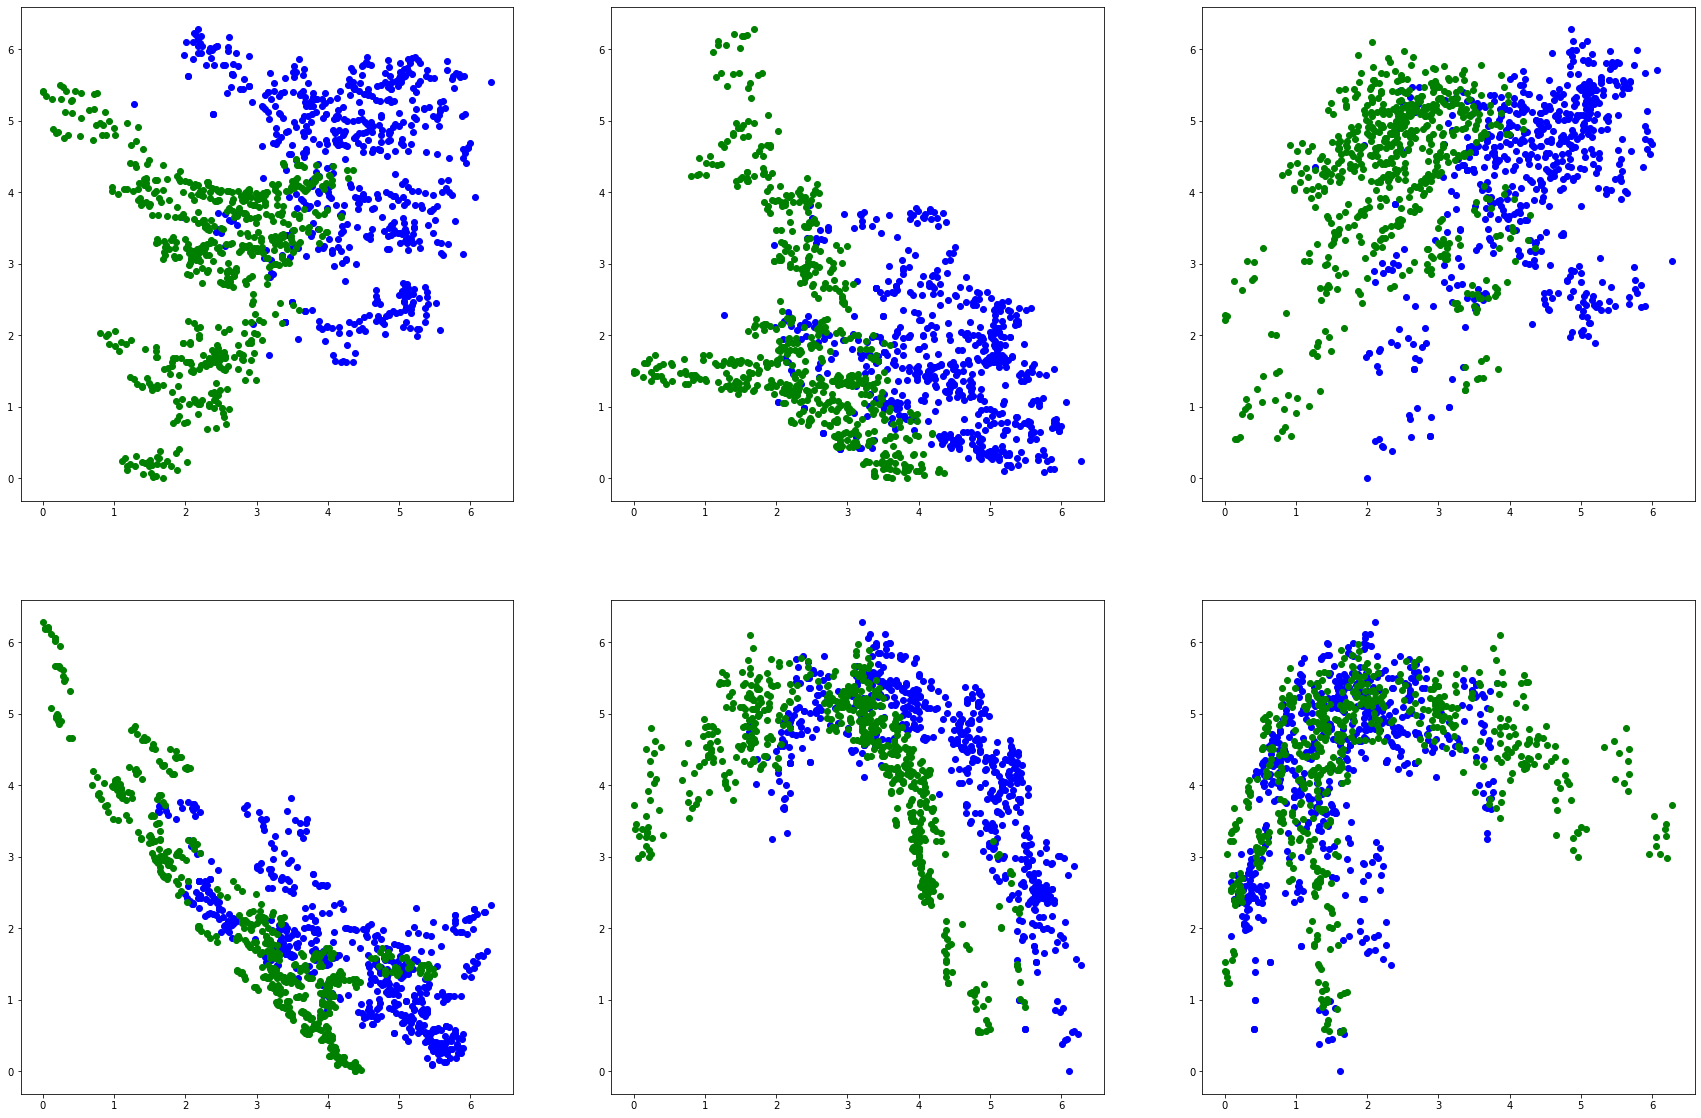

In [253]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

combos = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

for i in range(6):
    ax[i // 3, i % 3].scatter(bal_x[:num_samples, combos[i][0]], bal_x[:num_samples, combos[i][1]], c='b')
    ax[i // 3, i % 3].scatter(bal_x[num_samples:, combos[i][0]], bal_x[num_samples:, combos[i][1]], c='g')

In [147]:
data = np.genfromtxt('./experiment_data/ttt/tic-tac-toe.txt', dtype=str, delimiter=',')

labels = data[:, -1]
data = data[:, :-1]

labels = 2 * (labels == 'positive') - 1

xs = np.argwhere(data == 'x')
os = np.argwhere(data == 'o')
bs = np.argwhere(data == 'b')

for i in xs:
    data[i[0], i[1]] = '-1'
    
for i in os:
    data[i[0], i[1]] = '1'
    
for i in bs:
    data[i[0], i[1]] = '0'

data = data.astype('float32')

sel_data_inds = np.concatenate((np.random.choice(626, 332, False), np.arange(332) + 626))

bal_data = np.pi / 2 + data[sel_data_inds] * np.pi / 2
bal_labels = labels[sel_data_inds].astype('float')

np.savetxt('./experiment_data/ttt/data.txt', bal_data)
np.savetxt('./experiment_data/ttt/labels.txt', bal_labels)

train_inds = np.concatenate((np.random.choice(332, 300, False), np.random.choice(332, 300, False) + 332))

trains = np.zeros(664).astype('bool')

trains[train_inds] = True

train_x = bal_data[trains]
test_x = bal_data[np.invert(trains)]

train_y = bal_labels[trains]
test_y = bal_labels[np.invert(trains)]

np.savetxt('./experiment_data/ttt/x_train.txt', train_x)
np.savetxt('./experiment_data/ttt/x_test.txt', test_x)
np.savetxt('./experiment_data/ttt/y_train.txt', train_y)
np.savetxt('./experiment_data/ttt/y_test.txt', test_y)

In [58]:
scaled_data = all_data[:1600]

scaled_test = all_data[1600:]

np.savetxt('./experiment_data/mnist/x_train.txt', scaled_data)
np.savetxt('./experiment_data/mnist/x_test.txt', scaled_test)

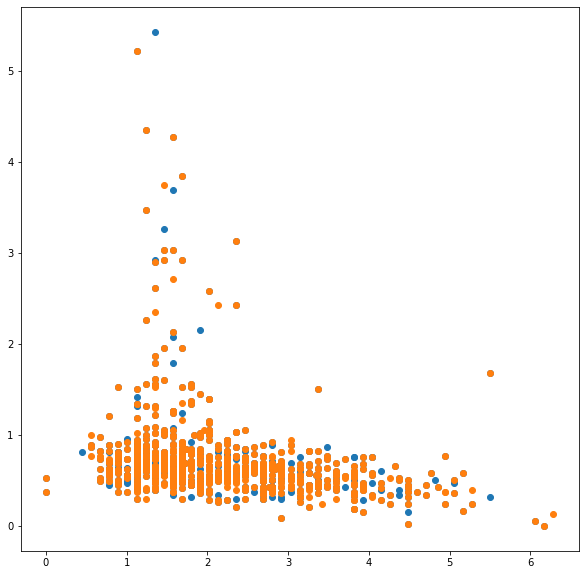

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(train_data[:800, 10], train_data[:800, 4])
ax.scatter(train_data[800:, 10], train_data[800:, 4])

## RUn supernet

In [ ]:
!python supernet/train_search.py --warmup_epochs 0 --epochs 50 --n_search 250 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_50_search_250 --data "./supernet/data" --save_dir "./supernet"
!python supernet/train_search.py --warmup_epochs 0 --epochs 50 --n_search 500 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_50_search_500 --data "./supernet/data" --save_dir "./supernet"

!python supernet/train_search.py --warmup_epochs 0 --epochs 100 --n_search 250 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_100_search_250 --data "./supernet/data" --save_dir "./supernet"
!python supernet/train_search.py --warmup_epochs 0 --epochs 100 --n_search 500 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_100_search_500 --data "./supernet/data" --save_dir "./supernet"

!python supernet/train_search.py --warmup_epochs 0 --epochs 250 --n_search 250 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_250_search_250 --data "./supernet/data" --save_dir "./supernet"
!python supernet/train_search.py --warmup_epochs 0 --epochs 250 --n_search 500 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_250_search_500 --data "./supernet/data" --save_dir "./supernet"

!python supernet/train_search.py --warmup_epochs 0 --epochs 500 --n_search 250 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_500_search_250 --data "./supernet/data" --save_dir "./supernet"
!python supernet/train_search.py --warmup_epochs 0 --epochs 500 --n_search 500 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_500_search_500 --data "./supernet/data" --save_dir "./supernet"

!python supernet/train_search.py --warmup_epochs 0 --epochs 1000 --n_search 250 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_1000_search_250 --data "./supernet/data" --save_dir "./supernet"
!python supernet/train_search.py --warmup_epochs 0 --epochs 1000 --n_search 500 --n_qubits 2 --n_experts 1 --n_layers 2 --save moons_train_1000_search_500 --data "./supernet/data" --save_dir "./supernet"

subnet: [13, 16], expert_idx: 0
subnet: [13, 16], loss: 0.3863363547670479, acc: 0.4041666666666667
subnet: [7, 9], expert_idx: 0
subnet: [7, 9], loss: 0.4888844716406538, acc: 0.2604166666666667


## Fourier series data generation

In [153]:
def generate_1d_fourier_data(freqs, num_samples, low=0, high=2 * np.pi):
    pos_x = np.random.uniform(low, high, num_samples)
    coeff_0 = 0.25 * np.random.sample()
    coeffs = 0.25 * (np.random.sample(len(freqs)) + 1j * np.random.sample(len(freqs)))
    data = np.complex128(np.zeros_like(pos_x))
    data += coeff_0
    
    for freq, coeff in zip(freqs, coeffs):
        exp = pos_x * 1j * freq
        data += coeff * np.exp(exp) + np.conj(coeff) * np.exp(-exp)
        
    return data.real, pos_x, [coeff_0] + list(coeffs)


def generate_nd_fourier_data(freqs, num_samples, low=0, high=2 * np.pi, d_type='regression', 
                             preference=2, scaling=1, sep=0.1, dim=2):
    pos_x1 = np.linspace(low, high, num_samples, endpoint=False)
    pos_x2 = np.linspace(low, high, num_samples, endpoint=False)
    
#     pos_xs = np.linspace(low, high, num_samples, endpoint=False)
#     pos_x = np.array(list(product(*[pos_xs for i in range(dim)])))
    pos_x = np.array([[x1, x2] for x1 in pos_x1 for x2 in pos_x2])

    freqs_1 = [[x, -x] for x in freqs[0]]
    freqs_1 = [0] + [j for x in freqs_1 for j in x]
    freqs_2 = [[x, -x] for x in freqs[1]]
    freqs_2 = [0] + [j for x in freqs_2 for j in x]
    combined_freqs = [(freq_1, freq_2) for freq_1 in freqs_1 for freq_2 in freqs_2]
    combined_freqs.remove((0, 0))
    coeffs_scaling = scaling
    
    coeff_0 = coeffs_scaling * np.random.sample()
    coeffs_list = coeffs_scaling * (np.random.uniform(1e-2, 1, len(combined_freqs))
                                    + 1j * np.random.uniform(1e-2, 1, len(combined_freqs)))
    coeffs = {(0, 0): coeff_0}
    index = 0
    
    for freq_combo in combined_freqs:
        if freq_combo not in coeffs.keys():
            coeffs[freq_combo] = coeffs_list[index]
            coeffs[tuple([-x for x in freq_combo])] = np.conj(coeffs_list[index])
            index += 1
            
    data = np.complex128(np.zeros_like(pos_x[:, 0]))

    for freq_combo in coeffs.keys():
        exp = 1j * (pos_x[:, 0] * freq_combo[0] + pos_x[:, 1] * freq_combo[1])
        data += coeffs[freq_combo] * np.exp(exp)

    data = data.real
    
    if d_type == 'classification':
        flags = data > sep / 2
        flags_2 = data <= -(sep / 2)
        probs_0 = np.power(np.abs(data[flags]), preference)
        probs_0 /= np.sum(probs_0)
        probs_1 = np.power(np.abs(data[flags_2]), preference)
        probs_1 /= np.sum(probs_1)
        
        class_1 = np.random.permutation(pos_x[flags_2])
        class_0 = np.random.permutation(pos_x[flags])
        
        class_1_sample_indices = np.random.choice(len(class_1), num_samples, False, probs_1)
        class_0_sample_indices = np.random.choice(len(class_0), num_samples, False, probs_0)
        
        class_1_samples = class_1[class_1_sample_indices]
        class_0_samples = class_0[class_0_sample_indices]
        
        pos_x = np.concatenate((class_0_samples, class_1_samples))
        data = np.concatenate((np.ones(num_samples), -1 * np.ones(num_samples)))
    
    return data, pos_x, coeffs

In [ ]:
generate_nd_fourier_data([[1], [1]], 50, d_type='classification', 
                                                       scaling=0.25, preference=1, sep=0.75, dim=3)

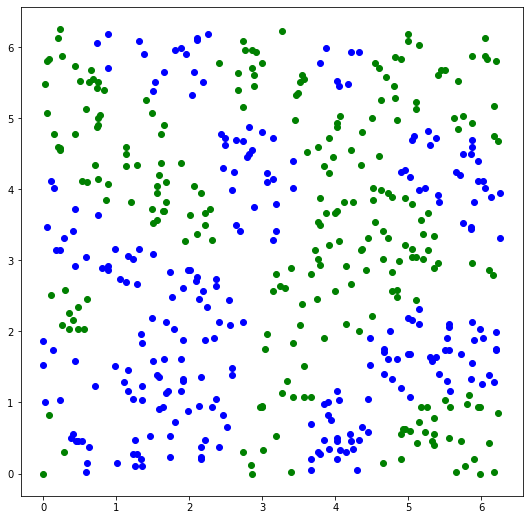

In [167]:
num_samples = 250
f_data_raw, f_pos_x, coeffs = generate_nd_fourier_data([[1, 2], [1, 2]], num_samples, d_type='classification', 
                                                       scaling=0.25, preference=1, sep=0.15)
# f_data = f_data_raw.reshape(num_samples, num_samples)

# print(coeffs)

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)
# im = ax.imshow(f_data, cmap='RdBu', extent=[0, 2 * np.pi, 0, 2* np.pi])
# cbar = ax.figure.colorbar(im, ax=ax)
ax.scatter(f_pos_x[:num_samples, 0], f_pos_x[:num_samples, 1], c='g')
ax.scatter(f_pos_x[num_samples:, 0], f_pos_x[num_samples:, 1], c='b')
plt.show()

In [168]:
fourier_data = np.concatenate((f_pos_x, f_pos_x), 1)
fourier_labels = f_data_raw

coeffs

{(0, 0): 0.09774479605064057,
 (0, 1): (0.05367117872598844+0.2072841920010453j),
 (0, -1): (0.05367117872598844-0.2072841920010453j),
 (0, 2): (0.08562741185911006+0.15785207026985634j),
 (0, -2): (0.08562741185911006-0.15785207026985634j),
 (1, 0): (0.11087211532755462+0.23743500020418543j),
 (-1, 0): (0.11087211532755462-0.23743500020418543j),
 (1, 1): (0.22981011204050916+0.23018278723291669j),
 (-1, -1): (0.22981011204050916-0.23018278723291669j),
 (1, -1): (0.023981970975190947+0.07237593529221639j),
 (-1, 1): (0.023981970975190947-0.07237593529221639j),
 (1, 2): (0.059937099450975806+0.23188136862226003j),
 (-1, -2): (0.059937099450975806-0.23188136862226003j),
 (1, -2): (0.03665568390116341+0.07015912345277708j),
 (-1, 2): (0.03665568390116341-0.07015912345277708j),
 (2, 0): (0.13252329843875202+0.07766470811896753j),
 (-2, 0): (0.13252329843875202-0.07766470811896753j),
 (2, 1): (0.2038225118506233+0.07772690541209883j),
 (-2, -1): (0.2038225118506233-0.07772690541209883j),
 (

In [ ]:
seps = [0.5, 0.25, 0.125, 0]
num_samples = 250

for i in range(100):
    f_data_raw, f_pos_x, coeffs = generate_2d_fourier_data([[1], [1]], num_samples, d_type='classification', 
                                                       scaling=0.25, preference=1, sep=seps[i // 25])   
    
    np.savetxt('./datasets/coeff_indep/freq_1_set_' + str(i + 1) + '.csv', 
               np.concatenate((f_pos_x, f_data_raw.reshape(num_samples * 2, 1)), 1), delimiter=',')

## Circuit coefficient computation and variance

In [ ]:
def extract_sparse_data(data, max_freq, labels=True):
    num_points = 2 * max_freq + 1
    n_dims = data.ndim if labels else data.ndim - 1
    dim_lengths = data.shape if labels else data.shape[:-1]
    step_sizes = [i / num_points for i in dim_lengths]

    indices = [[int(np.floor(step * j)) for j in range(num_points)] for step in step_sizes]
    point_indices = list(product(*indices))
    sparse_data = np.array([data[i] for i in point_indices])
    
    shape = [num_points for i in range(n_dims)]
    
    if not labels:
        shape = [num_points ** n_dims, data.shape[-1]]
            
    sparse_data = sparse_data.reshape(shape)
    
    return sparse_data


def single_dim_coeffs(data):
    coeffs = np.fft.rfft(data) / data.size
    return coeffs


def multi_dim_coeffs(data, max_freq, sparsified=False):
    num_points = max_freq + 1
    a = lambda x: x if x <= num_points // 2 else (x - num_points)
    check = lambda x: True if sum([1 if np.abs(i) <= max_freq else 0 for i in x]) == len(x) else False
    
    sparse_data = data if sparsified else extract_sparse_data(data, max_freq)
    
    coeffs = np.fft.rfftn(sparse_data) / sparse_data.size
    
    flags = np.abs(coeffs) > 1e-3
    coeff_indices = np.nonzero(flags)
    coeff_indices = [tuple([a(coeff_indices[j][i]) for j in range(len(coeff_indices))])
                     for i in range(len(coeff_indices[0]))]
    
    freq_coeffs = {tuple(i): 0 for i in list(product(*[range(-max_freq, max_freq + 1) for i in range(data.ndim)]))}
    
    for i in coeff_indices:
        if check(i):
            freq_coeffs[tuple(i)] = coeffs[i[0]][i[1]]
    
    return freq_coeffs


def compute_circ_coeffs(circ, params, data, num_samples, max_freq):
    num_points = 2 * max_freq + 1
    dims = data.ndim
    
    shaped_data = data.reshape([num_samples for i in range(dims)] + [data.shape[-1]])
    sparse_data = extract_sparse_data(shaped_data, max_freq, False)
    sparse_labels = np.array([circ(tf.constant(sample), params) for sample in sparse_data]).reshape(num_points, num_points)
    freq_coeffs = multi_dim_coeffs(sparse_labels, max_freq, True)
    
    return freq_coeffs


def sample_circ_coeffs(circ, data, num_data_samples, num_params, max_freq, num_coeff_samples):
    sampled_coeffs = {tuple(i): [[], []] for i in list(product(*[range(-max_freq, max_freq + 1) for i in range(data.ndim)]))}
    
    for i in range(num_coeff_samples):
        params = tf.constant(2 * np.pi * np.random.sample(num_params))
        coeffs = compute_circ_coeffs(circ, params, data, num_data_samples, max_freq)
    
        for i in sampled_coeffs.keys():
            sampled_coeffs[i][0].append(coeffs[i].real)
            sampled_coeffs[i][1].append(coeffs[i].imag)
    
    return sampled_coeffs


def compute_coeff_variance(sampled_coeffs):
    coeff_vars = dict()
    
    for i in sampled_coeffs.keys():
        coeff_vars[i] = np.var(sampled_coeffs[i][0]) + np.var(sampled_coeffs[i][1])
        
    return coeff_vars

## Run variational circuits on Fourier data (motivational examples)

### Frequency spectrum matches encoding spectrum - both 1 dimensional

In [ ]:
num_qubits = 1
layers = [rot_layer, ry_layer, rot_layer]
layer_extra_params = [[None], [None], [None]]
weights_bounds = [0, 3, 3, 6]
inputs_bounds = [0, 0, 1, 1]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

num_samples = 100
y, x, coeffs = generate_1d_fourier_data([1], num_samples, 0, 2 * np.pi)
plt.figure(figsize=[16, 9])
plt.scatter(x, y, c='g')
plt.show()

In [ ]:
weights, losses = train_qnn(circ, x, y, weights_bounds[-1], 50, 0.1, 25)

In [ ]:
y_preds = [circ(tf.constant([sample]), weights) for sample in x]
fig, ax = plt.subplots(1, 1, figsize=[16, 9])
ax.scatter(x, y_preds, facecolor="white", edgecolor='green')
ax.set_title('Predictions vs Ground Truth')
ax.scatter(x, y, facecolor="white", edgecolor='blue')
ax.legend(['Predictions', 'Ground Truth'])
plt.show()

### 1 dimensional - data frequency does not match encoding frequency

In [ ]:
num_qubits = 1
layers = [rot_layer, ry_layer, rot_layer]
layer_extra_params = [[None], [None], [None]]
weights_bounds = [0, 3, 3, 6]
inputs_bounds = [0, 0, 1, 1]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

num_samples = 100
y, x, coeffs = generate_1d_fourier_data([1, 2], num_samples, 0, 2 * np.pi)
plt.figure(figsize=[16, 9])
plt.scatter(x, y, c='g')
plt.show()

In [ ]:
weights, losses = train_qnn(circ, x, y, weights_bounds[-1], 25, 0.1, 25)

In [ ]:
y_preds = [circ(tf.constant([sample]), weights) for sample in x]
fig, ax = plt.subplots(1, 1, figsize=[16, 9])
ax.scatter(x, y_preds, facecolor="white", edgecolor='green')
ax.set_title('Predictions vs Ground Truth')
ax.scatter(x, y, facecolor="white", edgecolor='blue')
ax.legend(['Predictions', 'Ground Truth'])
plt.show()

### Example 2: data encoding frequency matches data generation frequency

In [ ]:
num_qubits = 1
layers = [rot_layer, ry_layer, rot_layer, ry_layer, rot_layer, ry_layer, rot_layer]
layer_extra_params = [[None], [None], [None], [None], [None], [None], [None]]
weights_bounds = [0, 3, 3, 6, 6, 9, 9, 12]
inputs_bounds = [0, 0, 1, 1, 2, 2, 3, 3]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

num_samples = 250
y, x, coeffs = generate_1d_fourier_data([1, 2, 3], num_samples, 0, 2 * np.pi)
padded_x = np.concatenate((x, x, x)).reshape(3, num_samples).T
plt.figure(figsize=[16, 9])
plt.scatter(x, y, c='g')
plt.show()

In [ ]:
weights, losses = train_qnn(circ, padded_x, y, weights_bounds[-1], 500, 0.01, 1)

In [ ]:
y_preds = [circ(tf.constant(sample), weights) for sample in padded_x]
fig, ax = plt.subplots(1, 1, figsize=[16, 9])
ax.scatter(x, y_preds, facecolor="white", edgecolor='green')
ax.set_title('Predictions vs Ground Truth')
ax.scatter(x, y, facecolor="white", edgecolor='blue')
ax.legend(['Predictions', 'Ground Truth'])
# ax.plot(losses)
plt.show()

### Circuit encoding freqs more than data encoding freqs

In [ ]:
num_qubits = 1
layers = [rot_layer, ry_layer, rot_layer, ry_layer, rot_layer, ry_layer, rot_layer, ry_layer, rot_layer]
layer_extra_params = [[None], [None], [None], [None], [None], [None], [None], [None], [None]]
weights_bounds = [0, 3, 3, 6, 6, 9, 9, 12, 12, 15]
inputs_bounds = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

num_samples = 250
y, x, coeffs = generate_1d_fourier_data([1, 2], num_samples, 0, 2 * np.pi)
padded_x = np.concatenate((x, x, x, x)).reshape(4, num_samples).T
plt.figure(figsize=[16, 9])
plt.scatter(x, y, c='g')
plt.show()

In [ ]:
weights, losses = train_qnn(circ, padded_x, y, weights_bounds[-1], 5000, 0.01, 1)

In [ ]:
y_preds = [circ(tf.constant(sample), weights) for sample in padded_x]
fig, ax = plt.subplots(1, 1, figsize=[16, 9])
ax.scatter(x, y_preds, facecolor="white", edgecolor='green')
ax.set_title('Predictions vs Ground Truth')
ax.scatter(x, y, facecolor="white", edgecolor='blue')
ax.legend(['Predictions', 'Ground Truth'])
# ax.plot(losses)
plt.show()

### 2 dimensional - data frequency spectrum matches encoding spectrum

In [ ]:
num_qubits = 2
layers = [rot_layer, c_layer, rx_layer, c_layer, rot_layer, c_layer, rot_layer]
layer_extra_params = [[None]] + [['cx', 'linear_rev', num_qubits], [None]] * 3

weights_bounds = [0, 6, 6, 6, 6, 12, 12, 18]
inputs_bounds = [0, 0, 0, 2, 0, 0, 0, 0]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

num_samples = 250
data, pos_x, coeffs = generate_2d_fourier_data([[1], [1]], num_samples, scaling=0.15)

fig = plt.figure(figsize=[16, 16])
ax = fig.add_subplot(111)
im = ax.imshow((data).reshape(num_samples, num_samples), cmap='RdBu', extent=[0, 2 * np.pi, 0, 2* np.pi])
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [ ]:
weights, losses = train_qnn(circ, pos_x, data, weights_bounds[-1], 10000, 0.1, 1)

In [ ]:
pos = np.linspace(0, 2 * np.pi, 100)
y_preds = np.array([circ(tf.constant([x_1, x_2]), weights) for x_1 in pos for x_2 in pos])

fig = plt.figure(figsize=[20, 9])
# ax = fig.add_subplot(121)
# ax.scatter()

ax1 = fig.add_subplot(122)
im = ax1.imshow((y_preds).reshape(num_samples, num_samples), cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])
cbar = ax1.figure.colorbar(im, ax=ax1)

plt.show()

### 2 dimensional - data frequency spectrum does not encoding spectrum 

In [ ]:
num_qubits = 2
layers = [rot_layer, c_layer, ry_layer, c_layer] + [rot_layer, c_layer] * 3 + [rot_layer]
layer_extra_params = [[None], ['cx', 'linear', 2], [None], ['cx', 'linear_rev', 2]]  + [
    [None], ['cx', 'linear', 2]] * 3 + [[None]] 

weights_bounds = [0, 6, 6, 6, 6, 12, 12, 18, 18, 24, 24, 30]
inputs_bounds = [0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

num_samples = 50
data, pos_x, coeffs = generate_2d_fourier_data([[1, 2], [1, 2]], num_samples)

fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)
im = ax.imshow((data).reshape(num_samples, num_samples), cmap='RdBu', extent=[0, 2 * np.pi, 0, 2* np.pi])
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [ ]:
weights, losses = train_qnn(circ, x, data, weights_bounds[-1], 15000, 0.01, 1)

In [ ]:
y_preds = np.array([circ(tf.constant(sample), weights) for sample in pos_x])

fig = plt.figure(figsize=[20, 9])
ax = fig.add_subplot(121)
im = ax.imshow((data).reshape(num_samples, num_samples), cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title('Ground truth')

ax1 = fig.add_subplot(122)
im = ax1.imshow((y_preds).reshape(num_samples, num_samples), cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])
cbar = ax1.figure.colorbar(im, ax=ax1)
ax1.set_title('Predictions')

plt.show()

print(circ.draw())

## Plot sampled circuit coefficients

In [ ]:
num_samples = 250
f_data_raw, f_pos_x, coeffs = generate_2d_fourier_data([[1], [1]], num_samples)
f_data = f_data_raw.reshape(num_samples, num_samples)

### 2 qubit embeddings - frequency 1, changing entanglement maps

RX + CX + ROT + CX (linear_rev)

In [ ]:
num_qubits = 2
layers = [rx_layer, c_layer, rot_layer, c_layer] * 1
layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits], [None], ['cx', 'linear_rev', num_qubits]] * 1

weights_bounds = [0, 0, 0, 6, 6]
inputs_bounds = [0, 2, 2, 2, 2]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)

max_freq = 1
sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 1000)

fig, ax = plt.subplots(2 * max_freq + 1, 2 * max_freq + 1, figsize=(25, 25))

for i in sampled_coeffs.keys():
    ax[max_freq + i[0], max_freq + i[1]].scatter(sampled_coeffs[i][0], sampled_coeffs[i][1], 
                                                 facecolor='white', edgecolor='green')

    ax[max_freq + i[0], max_freq + i[1]].set_title('Coeff {}'.format(i))
    ax[max_freq + i[0], max_freq + i[1]].set_xlim(-1, 1)
    ax[max_freq + i[0], max_freq + i[1]].set_ylim(-1, 1)
    
plt.show()

### 2 qubit embeddings - frequency 2, changing entanglement maps

In [ ]:
num_qubits = 2
layers = [rot_layer, c_layer] + [rx_layer, c_layer, rot_layer, c_layer] * 2
layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] + [[None], ['cx', 'linear_rev', num_qubits]] * 4

weights_bounds = [0, 6, 6, 6, 6, 12, 12, 12, 12, 18, 18]
inputs_bounds = [0, 0, 0, 2, 2, 2, 2, 4, 4, 4, 4]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)

max_freq = 2
sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 1000)

fig, ax = plt.subplots(2 * max_freq + 1, 2 * max_freq + 1, figsize=(25, 25))

for i in sampled_coeffs.keys():
    ax[max_freq + i[0], max_freq + i[1]].scatter(sampled_coeffs[i][0], sampled_coeffs[i][1], 
                                                 facecolor='white', edgecolor='green')

    ax[max_freq + i[0], max_freq + i[1]].set_title('Coeff {}'.format(i))
    ax[max_freq + i[0], max_freq + i[1]].set_xlim(-1, 1)
    ax[max_freq + i[0], max_freq + i[1]].set_ylim(-1, 1)
    
plt.show()

### 3 qubits - changing entanglement maps

In [ ]:
num_qubits = 2
layers = [rot_layer, c_layer, rx_layer, c_layer] + [rot_layer, c_layer] * 2
layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] * 4

weights_bounds = [0, 9, 9, 9, 9, 18, 18, 27, 27]
inputs_bounds = [0, 0, 0, 3, ]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)

max_freq = 2
sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 1000)

fig, ax = plt.subplots(2 * max_freq + 1, 2 * max_freq + 1, figsize=(25, 25))

for i in sampled_coeffs.keys():
    ax[max_freq + i[0], max_freq + i[1]].scatter(sampled_coeffs[i][0], sampled_coeffs[i][1], 
                                                 facecolor='white', edgecolor='green')

    ax[max_freq + i[0], max_freq + i[1]].set_title('Coeff {}'.format(i))
    ax[max_freq + i[0], max_freq + i[1]].set_xlim(-1, 1)
    ax[max_freq + i[0], max_freq + i[1]].set_ylim(-1, 1)
    
plt.show()

### 2 qubits - Changing number of variational gates

RX embedding - 2 variational layers

In [ ]:
num_qubits = 2
layers = [rx_layer, c_layer] + [rot_layer, c_layer] * 2
layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] + [[None], ['cx', 'linear_rev', num_qubits]] * 2

weights_bounds = [0, 0, 0, 6, 6, 12, 12]
inputs_bounds = [0, 2, 2, 2, 2, 2, 2]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)

max_freq = 1
sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 1000)

fig, ax = plt.subplots(2 * max_freq + 1, 2 * max_freq + 1, figsize=(25, 25))

for i in sampled_coeffs.keys():
    ax[max_freq + i[0], max_freq + i[1]].scatter(sampled_coeffs[i][0], sampled_coeffs[i][1], 
                                                 facecolor='white', edgecolor='green')

    ax[max_freq + i[0], max_freq + i[1]].set_title('Coeff {}'.format(i))
    ax[max_freq + i[0], max_freq + i[1]].set_xlim(-1, 1)
    ax[max_freq + i[0], max_freq + i[1]].set_ylim(-1, 1)
    
plt.show()

3 variational layers

In [ ]:
num_qubits = 2
layers = [rx_layer, c_layer] + [rot_layer, c_layer] * 3
layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] + [[None], ['cx', 'linear_rev', num_qubits]] * 3

weights_bounds = [0, 0, 0, 6, 6, 12, 12, 18, 18]
inputs_bounds = [0, 2, 2, 2, 2, 2, 2, 2, 2]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)

max_freq = 1
sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 1000)

fig, ax = plt.subplots(2 * max_freq + 1, 2 * max_freq + 1, figsize=(25, 25))

for i in sampled_coeffs.keys():
    ax[max_freq + i[0], max_freq + i[1]].scatter(sampled_coeffs[i][0], sampled_coeffs[i][1], 
                                                 facecolor='white', edgecolor='green')

    ax[max_freq + i[0], max_freq + i[1]].set_title('Coeff {}'.format(i))
    ax[max_freq + i[0], max_freq + i[1]].set_xlim(-1, 1)
    ax[max_freq + i[0], max_freq + i[1]].set_ylim(-1, 1)
    
plt.show()

4 variational layers

In [ ]:
num_qubits = 2
layers = [rx_layer, c_layer] + [rot_layer, c_layer] * 4
layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] + [[None], ['cx', 'linear_rev', num_qubits]] * 4

weights_bounds = [0, 0, 0, 6, 6, 12, 12, 18, 18, 24, 24]
inputs_bounds = [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)

max_freq = 1
sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 1000)

fig, ax = plt.subplots(2 * max_freq + 1, 2 * max_freq + 1, figsize=(25, 25))

for i in sampled_coeffs.keys():
    ax[max_freq + i[0], max_freq + i[1]].scatter(sampled_coeffs[i][0], sampled_coeffs[i][1], 
                                                 facecolor='white', edgecolor='green')

    ax[max_freq + i[0], max_freq + i[1]].set_title('Coeff {}'.format(i))
    ax[max_freq + i[0], max_freq + i[1]].set_xlim(-1, 1)
    ax[max_freq + i[0], max_freq + i[1]].set_ylim(-1, 1)
    
plt.show()

## Changes in circuit coefficient variance

In [ ]:
num_samples = 250
f_data_raw, f_pos_x, coeffs = generate_2d_fourier_data([[1, 2, 3], [1, 2, 3]], num_samples)
f_data = f_data_raw.reshape(num_samples, num_samples)

In [ ]:
num_qubits = 2
weights_bounds = [0, 0, 0, 6, 6, 12, 12, 18, 18, 24, 24, 30, 30, 36, 36, 42, 42, 48, 48, 54, 54, 60, 60]
inputs_bounds = [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
measured_qubits = [0]

dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)
max_freq = 1

coeff_vars = []
num_var_layers = 10

for i in range(1, num_var_layers + 1):
    layers = [rx_layer, c_layer] +  [rot_layer, c_layer] * i
    layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] + [[None], ['cx', 'linear_rev', num_qubits]] * i

    circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

    sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 100)
    coeff_var = compute_coeff_variance(sampled_coeffs)
    coeff_vars.append(coeff_var)
    
for i in coeff_vars[0].keys():
    print('Freq combo:' + str(i) + '\n ---------')
    print(('|' + ' {:.4f} |' * num_var_layers).format(*[coeff_vars[j][i] for j in range(num_var_layers)]))
    print()

## Investigate coefficient independence

In [ ]:
num_qubits = 2

weights_bounds = [0, 6, 6, 6, 6, 12, 12, 12, 12, 18, 18, 24, 24, 30, 30, 36, 36, 42, 42]
inputs_bounds = [0, 0, 0, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)

padded_data = np.concatenate((f_pos_x, f_pos_x), 1)
max_freq = 2
freq_combos = [(0, 0), (0, 1), (0, 2), (1, -2), (1, -1), (1, 0), (1, 1), (1, 2), (2, -2), (2, -1), (2, 0), (2, 1), (2, 2)]
cs = []

for l in range(1, 6):
    num_extra_var_layers = l
    layers = [rot_layer, c_layer, rx_layer, c_layer] * 2 + [rot_layer, c_layer] * num_extra_var_layers
    layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] * (4 + num_extra_var_layers)

    circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

    sampled_coeffs = sample_circ_coeffs(circ, padded_data, 250, 3 * num_qubits * (2 + num_extra_var_layers), max_freq, 1000)
    cs.append(sampled_coeffs)
    num_combos = len(list(sampled_coeffs.keys())) // 2 + 1
    
    fig, ax = plt.subplots(2 * num_combos, 2 * num_combos, figsize=(10 * len(freq_combos), 10 * len(freq_combos)))

    for i in range(num_combos):
        for j in range(num_combos):
            for k in range(4):
                ax[2 * i + (k // 2), 2 * j + (k % 2)].scatter(
                    sampled_coeffs[freq_combos[j]][k % 2], sampled_coeffs[freq_combos[i]][k // 2])
                
                ax[2 * i + (k // 2), 2 * j + (k % 2)].set_xlim(-0.5, 0.5)
                ax[2 * i + (k // 2), 2 * j + (k % 2)].set_ylim(-0.5, 0.5)

        ax[0, 2 * i].set_title(str(freq_combos[i]) + '.real', fontsize=20)
        ax[0, 2 * i + 1].set_title(str(freq_combos[i]) + '.imag', fontsize=20)
        ax[2 * i, 0].set_ylabel(str(freq_combos[i]) + '.real', fontsize=20)
        ax[2 * i + 1, 0].set_ylabel(str(freq_combos[i]) + '.imag', fontsize=20)

    fig.suptitle('2 qubit circuit coefficient variation: ROT + CX (1 -> 0) + RX (embedding) + CX (1 -> 0) + ROT + CX (1 -> 0) + RX (embedding) + (ROT + CX (1 -> 0)) * ' + str(num_extra_var_layers), 
                 fontsize=40)
    
    fig.savefig('./coeff_plots/2_qubits/2_qubit_var_1_rx_2_var_' + str(num_extra_var_layers) + '_linearrev.png')

## Test correlation between coeff independence and average performance

In [ ]:
num_qubits = 2
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)
measured_qubits = [0]
weights_bounds = [0, 6, 6] + [6 * (1 + i // 2) for i in range(18)]
inputs_bounds = [0, 0, 0] + [2 for i in range(18)]
final_accs = [[] for i in range(8)]

for i in range(1, 9):
    layers = [rot_layer, c_layer, rx_layer, c_layer] + [rot_layer, c_layer] * i
    layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] * 2 + [[None], ['cx', 'linear_rev', num_qubits]] * i

    circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)
    print('-------------------------------')
    print('Circuit {}'.format(i))
    print('-------------------------------')
    
    for j in range(1, 101):
        data = np.genfromtxt('./datasets/coeff_indep/freq_1_set_' + str(j) + '.csv', delimiter=',')
        labels = data[:, -1]
        feats = data[:, :-1]
        
        weights, losses = train_qnn(circ, feats, labels, weights_bounds[4 + 2 * i], 10000, 0.1, 1, False)
        acc = compute_qnn_acc(circ, feats, labels, weights)
        print('Dataset {}: Accuracy : {}'.format(j, acc))
        final_accs[i].append(acc)
        
    print('\n\n\n')

In [ ]:
np.savetxt('./accs.csv', np.array(final_accs), delimiter=',')

## How many samples do we need to get a good estimate of the variance?

In [ ]:
num_samples = 250
f_data_raw, f_pos_x, coeffs = generate_2d_fourier_data([[1], [1]], num_samples)
f_data = f_data_raw.reshape(num_samples, num_samples)

In [ ]:
num_qubits = 2
layers = [rot_layer, c_layer] + [rx_layer, c_layer] + [rot_layer, c_layer] * 2
layer_extra_params = [[None], ['cx', 'linear_rev', num_qubits]] * 2 + [[None], ['cx', 'linear_rev', num_qubits]] * 2

weights_bounds = [0, 6, 6, 6, 6, 12, 12, 18, 18]
inputs_bounds = [0, 0, 0, 2, 2, 2, 2, 2, 2]
measured_qubits = [0]
dev = qiskit_dev = qml.device('default.qubit', wires=num_qubits)
padded_data = np.concatenate((f_pos_x, f_pos_x), 1)

circ = torch_qnn_generator(dev, num_qubits, layers, layer_extra_params, weights_bounds, inputs_bounds, measured_qubits)

max_freq = 1
ref_coeffs = sample_circ_coeffs(circ, padded_data, 250, 18, max_freq, 2500)
ref_vars = compute_coeff_variance(ref_coeffs)

In [ ]:
step = 25
pred_vars = [dict() for i in range(2500 // step)]

for i in range(2500 // step):
    samples = (1 + i) * step
    subset_coeffs = {j:[ref_coeffs[j][0][:samples], ref_coeffs[j][1][:samples]] for j in ref_vars.keys()}
    
    for j in ref_vars.keys():
        pred_vars[i][j] = np.var(subset_coeffs[j][0]) + np.var(subset_coeffs[j][1])

pred_var_diffs = dict()
    
for j in ref_vars.keys():
    pred_var_diffs[j] = [np.abs(ref_vars[j] - pred_vars[i][j]) / ref_vars[j] for i in range(2500 // step)]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for j in pred_var_diffs.keys():
    ax.plot([step * (i + 1) for i in range(2500 // step)], pred_var_diffs[j], label=str(j))
    
ax.legend()
ax.set_xlim(0, 100)